In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#import dataset
df = pd.read_csv ('WinnipegDataset.txt',sep = ",")

## Exploratory Data Analysis

In [2]:
# determine data types in dataset
df.dtypes

label      int64
f1       float64
f2       float64
f3       float64
f4       float64
f5       float64
f6       float64
f7       float64
f8       float64
f9       float64
f10      float64
f11      float64
f12      float64
f13      float64
f14      float64
f15      float64
f16      float64
f17      float64
f18      float64
f19      float64
f20      float64
f21      float64
f22      float64
f23      float64
f24      float64
f25      float64
f26      float64
f27      float64
f28      float64
f29      float64
f30      float64
f31      float64
f32      float64
f33      float64
f34      float64
f35      float64
f36      float64
f37      float64
f38      float64
f39      float64
f40      float64
f41      float64
f42      float64
f43      float64
f44      float64
f45      float64
f46      float64
f47      float64
f48      float64
f49      float64
f50      float64
f51      float64
f52      float64
f53      float64
f54      float64
f55      float64
f56      float64
f57      float64
f58      float

In [3]:
#display attributes
display(df)

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.404,-15.248,-11.923,-15.291,-2.155,-7.847,-10.002,0.042,3.325,3.368,0.356,0.058,0.585,0.241,0.519,0.239,-0.624,-0.815,-0.708,-0.656,-0.196,-0.632,0.092,0.027,0.005,0.620,0.684,44.369,0.424,0.196,0.260,0.120,0.055,0.162,-11.923,-12.823,-21.407,0.176,0.168,0.003,0.066,0.025,0.028,0.057,0.037,0.006,0.025,-12.564,-23.436,-13.858,-18.209,-11.556,-17.934,1.294,-10.873,-9.578,-0.275,6.652,6.378,0.548,0.045,0.407,0.149,0.691,0.159,-1.873,-0.785,-1.990,-2.997,-1.774,-1.733,0.071,0.025,0.004,0.664,0.705,42.797,0.468,0.196,0.237,0.099,0.062,0.174,-11.556,-15.740,-23.436,0.182,0.119,0.003,0.058,0.020,0.018,0.059,0.019,0.004,0.016,0.009,0.057,0.048,0.165,0.369,0.770,7.688,1.188,0.505,0.618,0.525,0.086,0.732,0.503,0.382,2.236,-0.486,17.280,0.549,0.128,7.380,3.438,22.667,8.222,0.275,13.444,3.000,2.197,0.111,0.453,7.778,17.284,0.276,24.556,3.667,2.043,0.136,0.651,6711,6143,4570,5064,8212,0.285,1.797,1.344,-0.619,0.543,0.427,0.147,0.144,0.586,0.237,1.622,0.237,294110.000,0.051,2199.400,92560.000,1.108,48.444,3.136,0.578,2.444,1.111,1.831,0.185,0.726,5.333,6.000,0.295,9.778,2.444,1.677,0.210,0.654
1,1,-12.802,-20.335,-10.399,-14.132,-11.096,-14.361,-2.404,-7.533,-9.937,0.228,3.036,3.264,0.343,0.061,0.597,0.252,0.508,0.240,-0.572,-0.749,-0.648,-0.628,-0.188,-0.554,0.116,0.031,0.006,0.604,0.675,44.992,0.407,0.196,0.268,0.129,0.052,0.158,-11.096,-11.805,-20.335,0.189,0.182,0.006,0.079,0.027,0.034,0.067,0.043,0.006,0.028,-11.559,-22.730,-12.844,-17.334,-10.500,-17.095,1.285,-11.172,-9.886,-0.239,6.834,6.595,0.549,0.042,0.409,0.145,0.701,0.154,-1.955,-0.753,-1.978,-2.940,-1.828,-1.755,0.091,0.031,0.005,0.651,0.715,42.706,0.466,0.185,0.249,0.099,0.057,0.163,-10.500,-14.859,-22.730,0.201,0.130,0.002,0.072,0.023,0.020,0.073,0.023,0.004,0.019,0.001,0.044,0.037,0.103,0.290,0.774,7.838,1.189,0.420,0.598,0.459,0.086,0.737,0.425,0.476,2.816,-0.401,16.240,0.471,0.099,4.240,2.784,18.556,0.469,0.600,1.333,0.889,1.523,0.235,-0.132,3.889,0.321,0.722,0.556,0.556,1.273,0.309,0.105,6274,5084,3297,3777,8214,0.427,2.491,1.542,-0.645,0.925,0.641,0.213,0.235,0.751,0.370,2.175,0.370,412400.000,0.068,2338.400,100280.000,1.146,49.778,0.395,0.467,1.333,1.111,1.215,0.333,-0.488,2.111,0.099,0.833,0.333,0.333,0.849,0.506,-0.189
2,1,-12.431,-19.902,-10.074,-13.598,-10.829,-14.048,-2.357,-7.472,-9.828,0.450,2.769,3.219,0.345,0.062,0.593,0.264,0.499,0.238,-0.533,-0.703,-0.588,-0.618,-0.178,-0.486,0.127,0.032,0.006,0.587,0.680,45.466,0.399,0.188,0.281,0.132,0.048,0.149,-10.829,-11.377,-19.902,0.196,0.191,0.010,0.027,0.086,0.040,0.073,0.047,0.006,0.030,-11.040,-22.566,-12.458,-16.903,-9.997,-16.873,1.418,-11.526,-10.108,-0.031,6.907,6.876,0.558,0.039,0.403,0.145,0.710,0.146,-2.361,-0.724,-2.128,-3.689,-2.106,-1.668,0.102,0.034,0.005,0.638,0.721,42.195,0.460,0.178,0.261,0.101,0.053,0.154,-9.997,-14.509,-22.566,0.216,0.138,0.000,0.084,0.026,0.021,0.084,0.026,0.004,0.021,0.001,0.046,0.046,0.107,0.298,0.733,6.478,1.000,0.402,0.532,0.448,0.000,0.733,0.393,0.472,2.785,-0.399,16.580,0.399,0.098,3.660,2.326,19.000,0.667,0.578,2.444,1.111,1.677,0.210,0.317,3.889,0.321,0.667,0.667,0.667,1.273,0.309,0.614,6215,5035,3033,3837,8588,0.478,2.832,1.660,-0.700,1.035,0.717,0.248,0.261,0.809,0.382,2.238,0.382,439570.000,0

In [4]:
# identifies columns having null values as a list
df.columns[df.isna().any()].tolist()

[]

(array([39162.,  3598., 75673., 74067., 47117., 85074.,  1143.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <BarContainer object of 7 artists>)

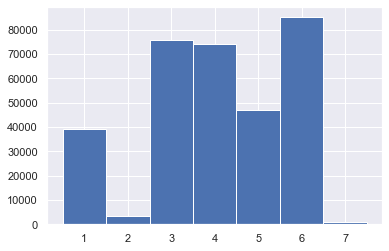

In [5]:
# plot histogram of label column
plt.hist(df['label'], bins=np.arange(df['label'].min(), df['label'].max()+2)-0.5)

<ipython-input-6-16d84b1e181f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

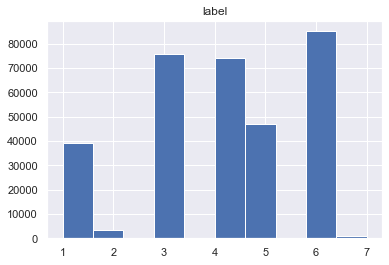

<Figure size 432x288 with 0 Axes>

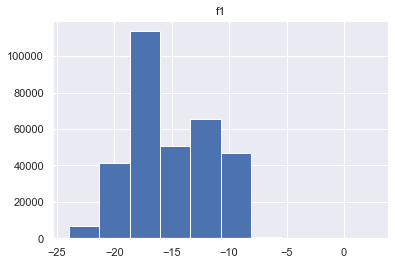

<Figure size 432x288 with 0 Axes>

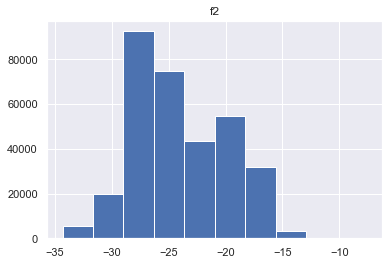

<Figure size 432x288 with 0 Axes>

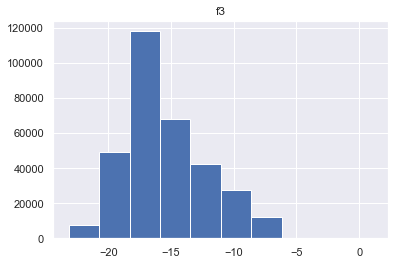

<Figure size 432x288 with 0 Axes>

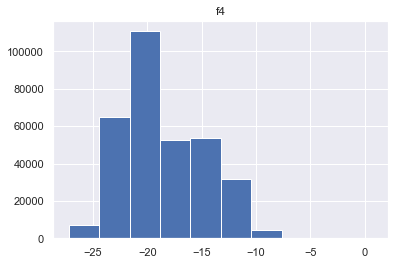

<Figure size 432x288 with 0 Axes>

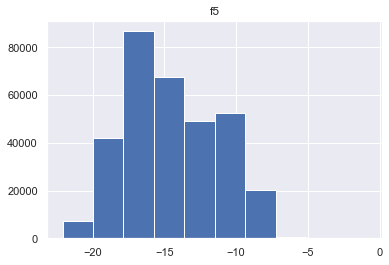

<Figure size 432x288 with 0 Axes>

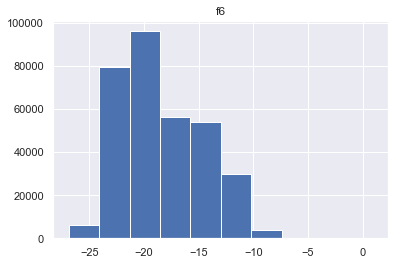

<Figure size 432x288 with 0 Axes>

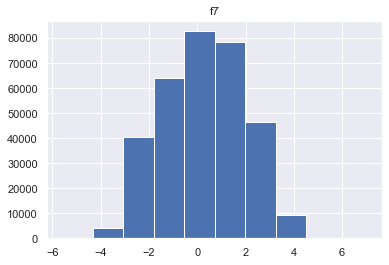

<Figure size 432x288 with 0 Axes>

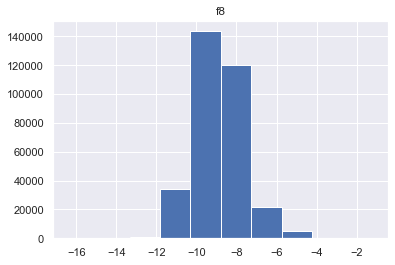

<Figure size 432x288 with 0 Axes>

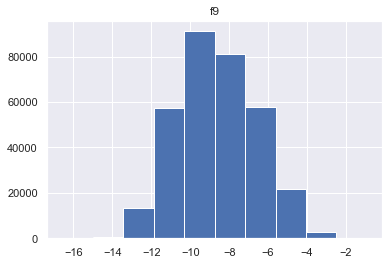

<Figure size 432x288 with 0 Axes>

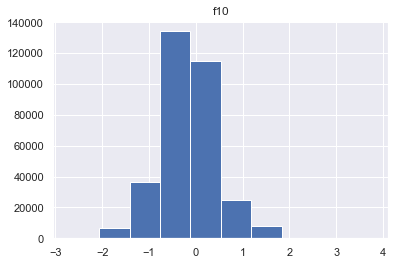

<Figure size 432x288 with 0 Axes>

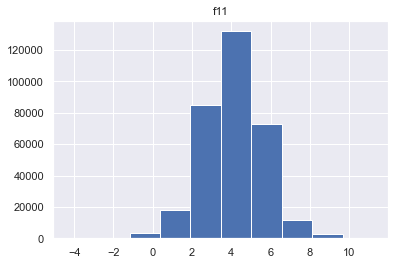

<Figure size 432x288 with 0 Axes>

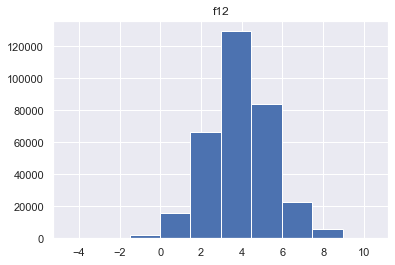

<Figure size 432x288 with 0 Axes>

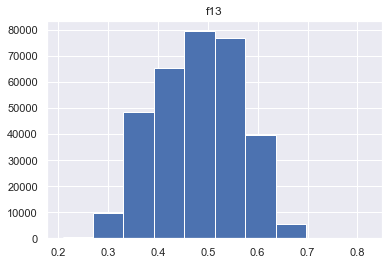

<Figure size 432x288 with 0 Axes>

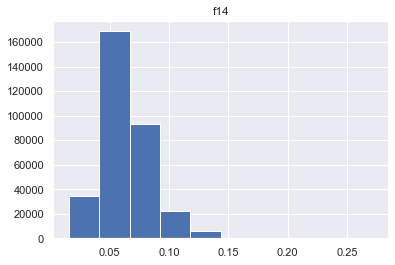

<Figure size 432x288 with 0 Axes>

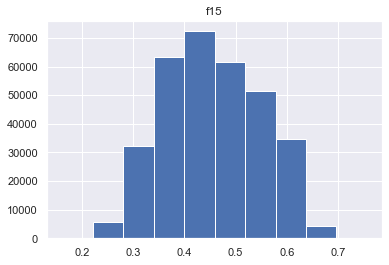

<Figure size 432x288 with 0 Axes>

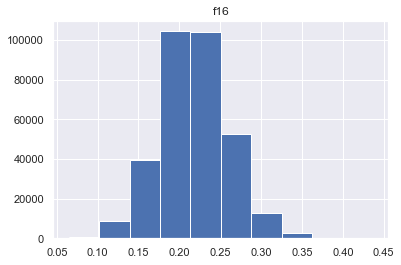

<Figure size 432x288 with 0 Axes>

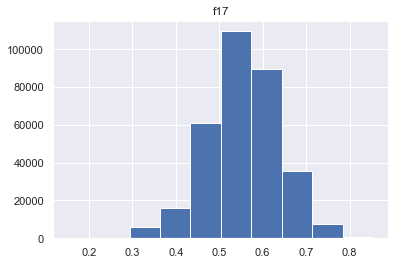

<Figure size 432x288 with 0 Axes>

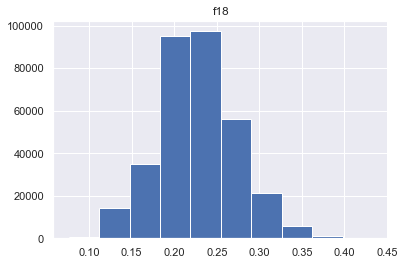

<Figure size 432x288 with 0 Axes>

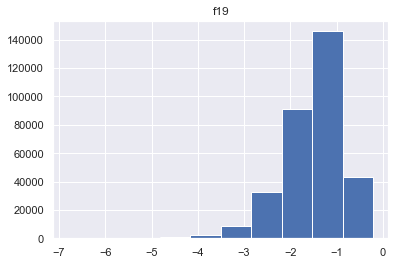

<Figure size 432x288 with 0 Axes>

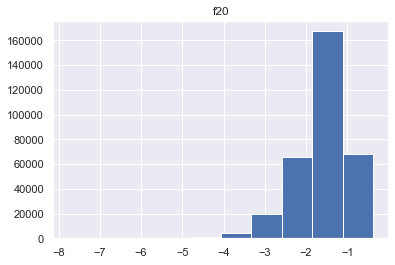

<Figure size 432x288 with 0 Axes>

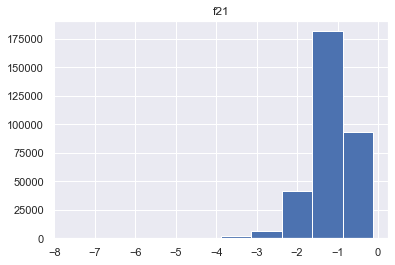

<Figure size 432x288 with 0 Axes>

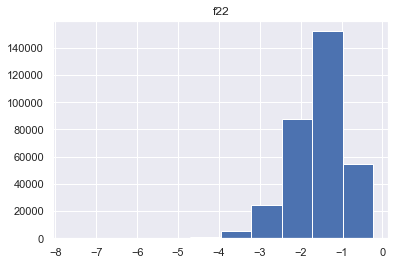

<Figure size 432x288 with 0 Axes>

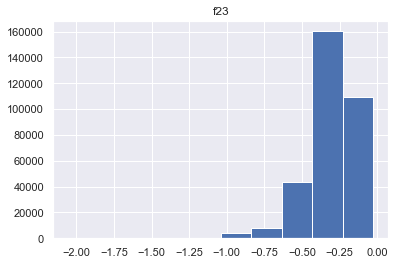

<Figure size 432x288 with 0 Axes>

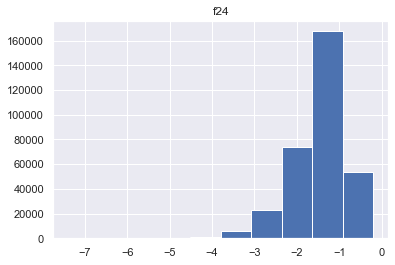

<Figure size 432x288 with 0 Axes>

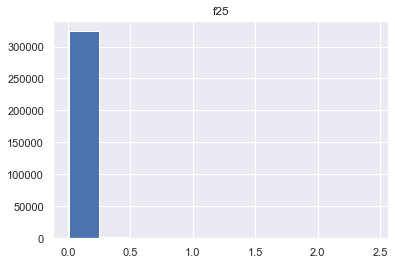

<Figure size 432x288 with 0 Axes>

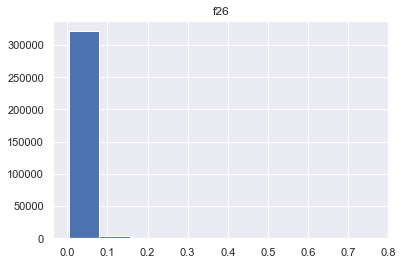

<Figure size 432x288 with 0 Axes>

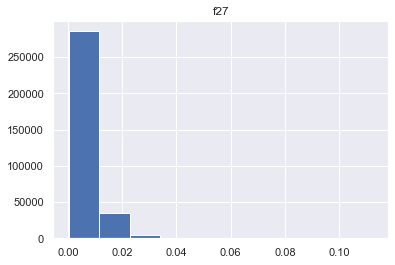

<Figure size 432x288 with 0 Axes>

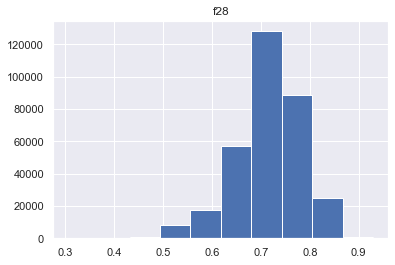

<Figure size 432x288 with 0 Axes>

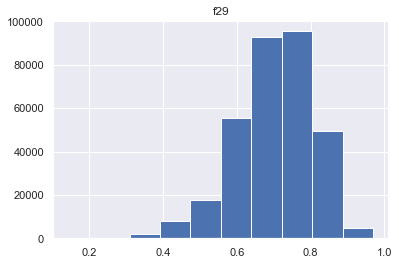

<Figure size 432x288 with 0 Axes>

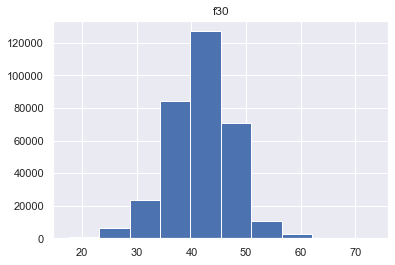

<Figure size 432x288 with 0 Axes>

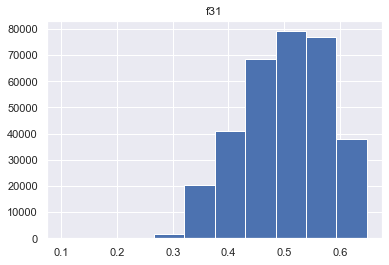

<Figure size 432x288 with 0 Axes>

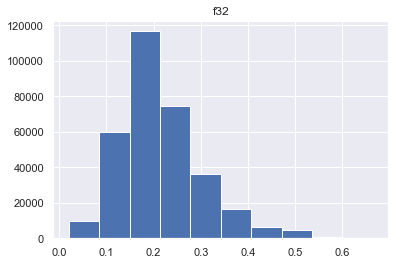

<Figure size 432x288 with 0 Axes>

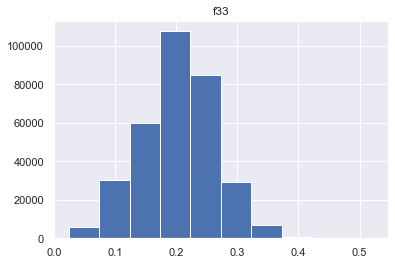

<Figure size 432x288 with 0 Axes>

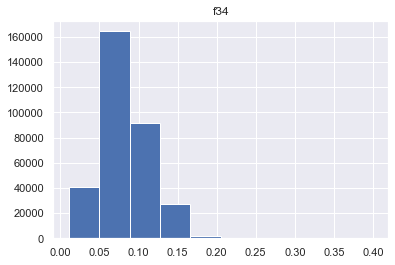

<Figure size 432x288 with 0 Axes>

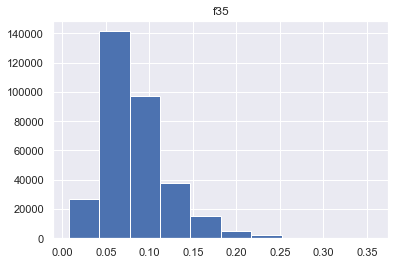

<Figure size 432x288 with 0 Axes>

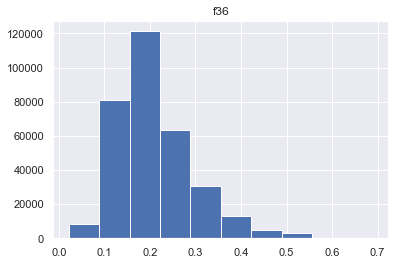

<Figure size 432x288 with 0 Axes>

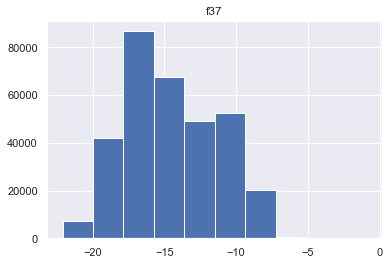

<Figure size 432x288 with 0 Axes>

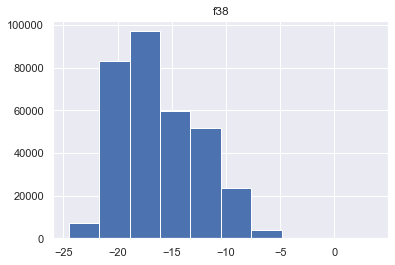

<Figure size 432x288 with 0 Axes>

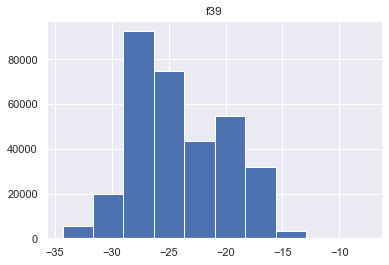

<Figure size 432x288 with 0 Axes>

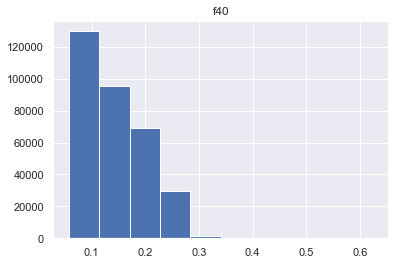

<Figure size 432x288 with 0 Axes>

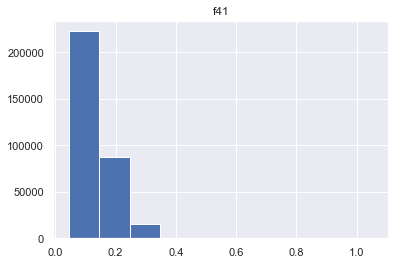

<Figure size 432x288 with 0 Axes>

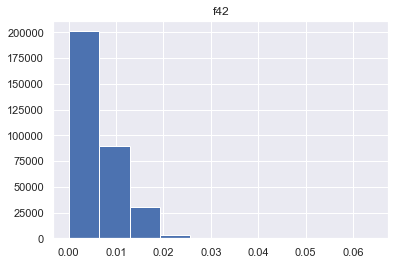

<Figure size 432x288 with 0 Axes>

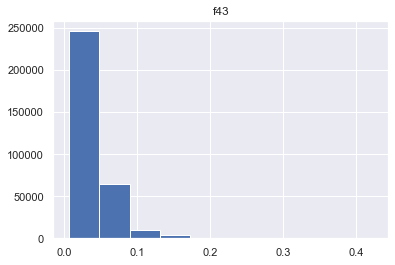

<Figure size 432x288 with 0 Axes>

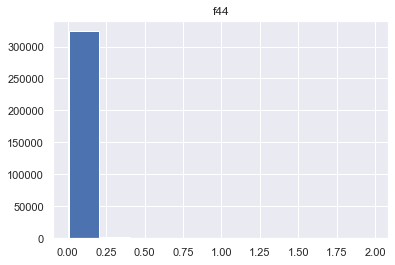

<Figure size 432x288 with 0 Axes>

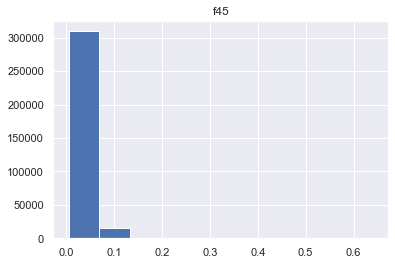

<Figure size 432x288 with 0 Axes>

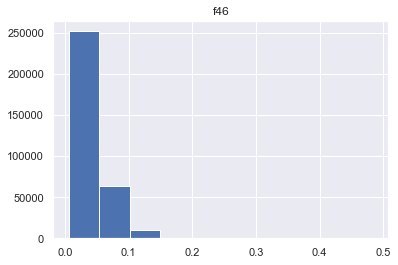

<Figure size 432x288 with 0 Axes>

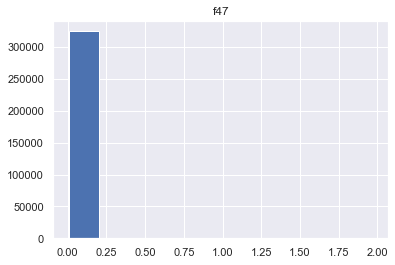

<Figure size 432x288 with 0 Axes>

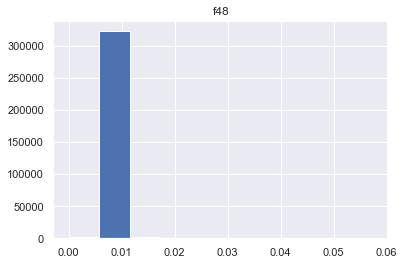

<Figure size 432x288 with 0 Axes>

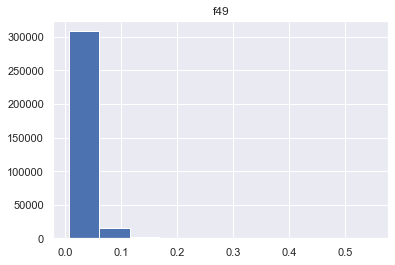

<Figure size 432x288 with 0 Axes>

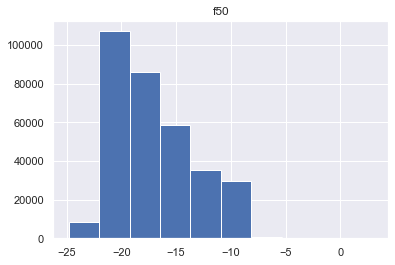

<Figure size 432x288 with 0 Axes>

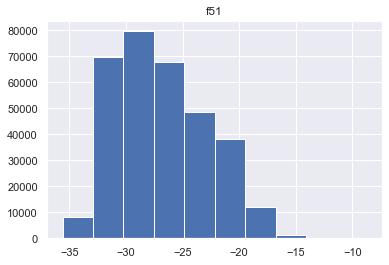

<Figure size 432x288 with 0 Axes>

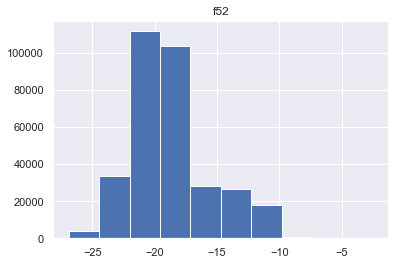

<Figure size 432x288 with 0 Axes>

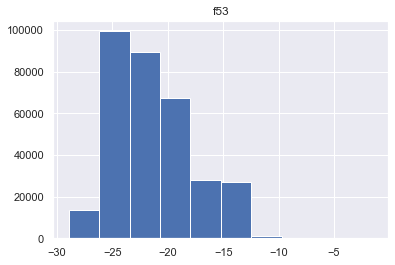

<Figure size 432x288 with 0 Axes>

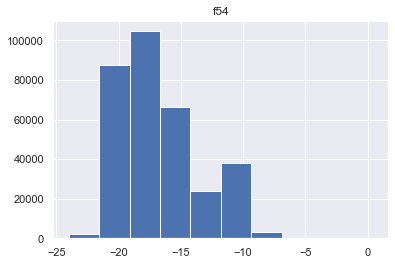

<Figure size 432x288 with 0 Axes>

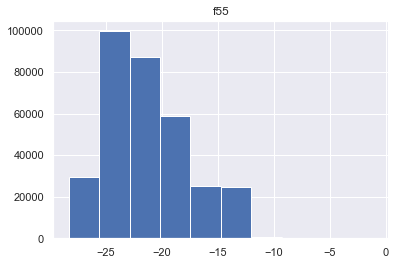

<Figure size 432x288 with 0 Axes>

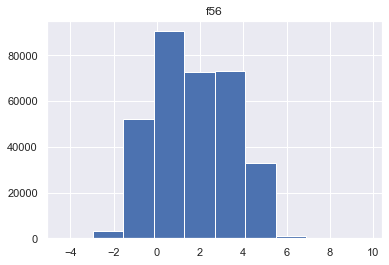

<Figure size 432x288 with 0 Axes>

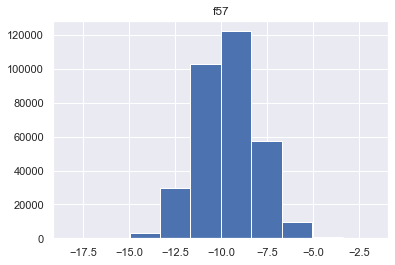

<Figure size 432x288 with 0 Axes>

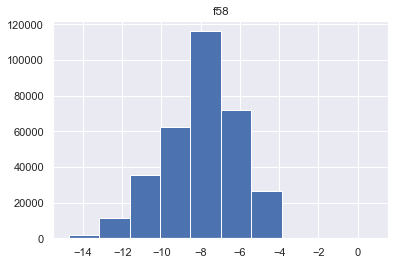

<Figure size 432x288 with 0 Axes>

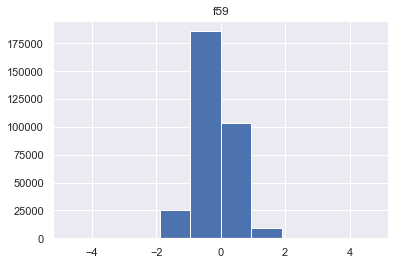

<Figure size 432x288 with 0 Axes>

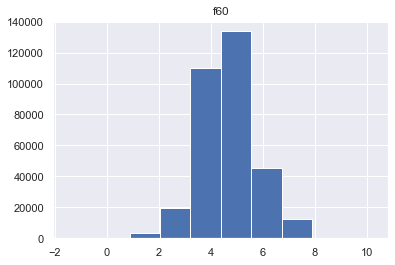

<Figure size 432x288 with 0 Axes>

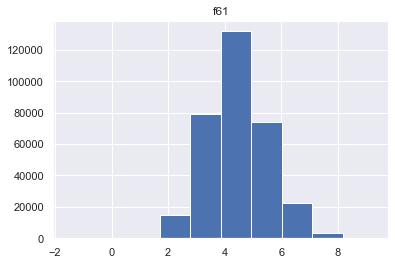

<Figure size 432x288 with 0 Axes>

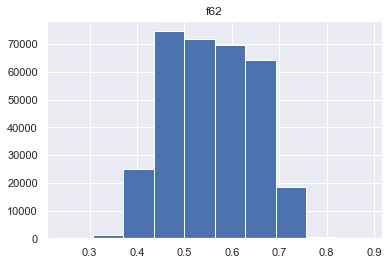

<Figure size 432x288 with 0 Axes>

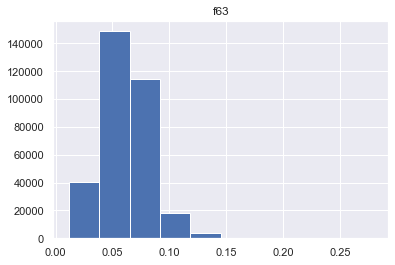

<Figure size 432x288 with 0 Axes>

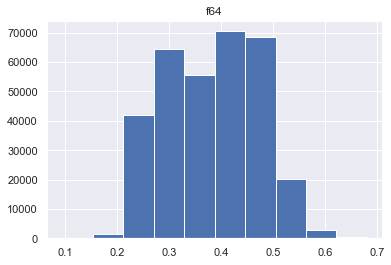

<Figure size 432x288 with 0 Axes>

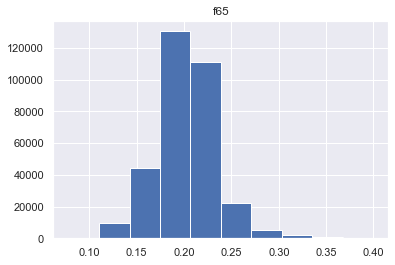

<Figure size 432x288 with 0 Axes>

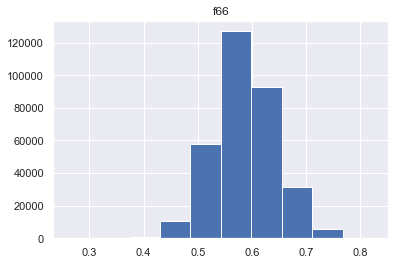

<Figure size 432x288 with 0 Axes>

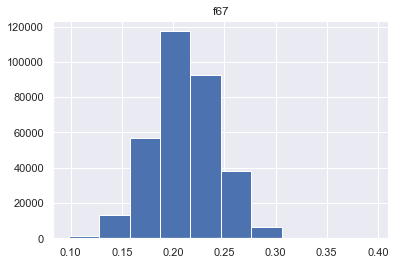

<Figure size 432x288 with 0 Axes>

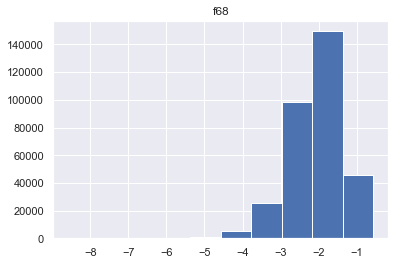

<Figure size 432x288 with 0 Axes>

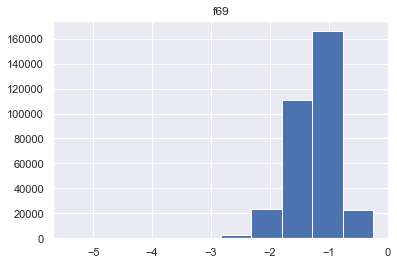

<Figure size 432x288 with 0 Axes>

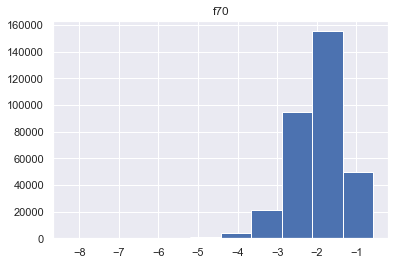

<Figure size 432x288 with 0 Axes>

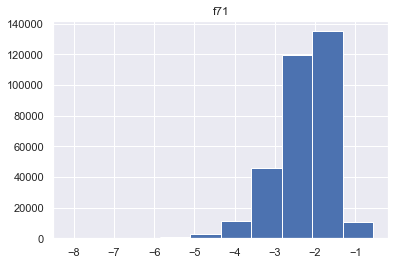

<Figure size 432x288 with 0 Axes>

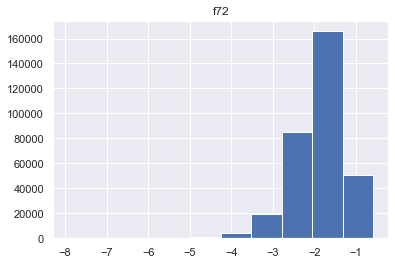

<Figure size 432x288 with 0 Axes>

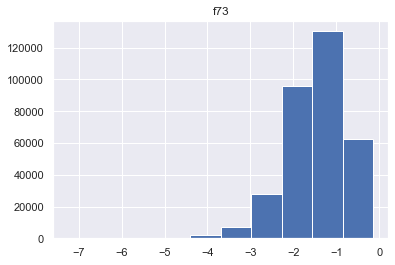

<Figure size 432x288 with 0 Axes>

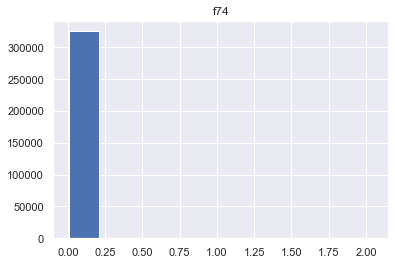

<Figure size 432x288 with 0 Axes>

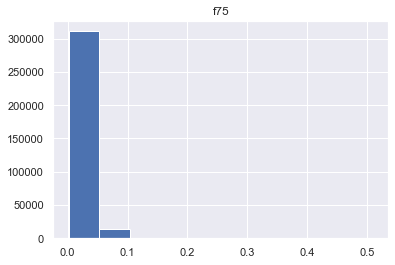

<Figure size 432x288 with 0 Axes>

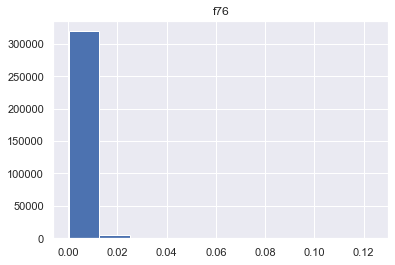

<Figure size 432x288 with 0 Axes>

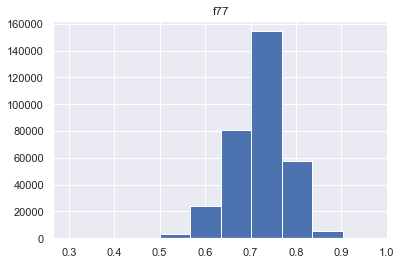

<Figure size 432x288 with 0 Axes>

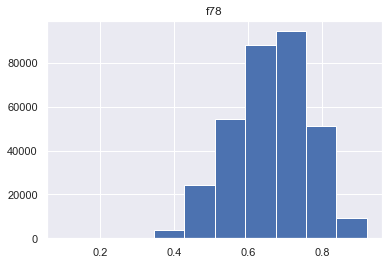

<Figure size 432x288 with 0 Axes>

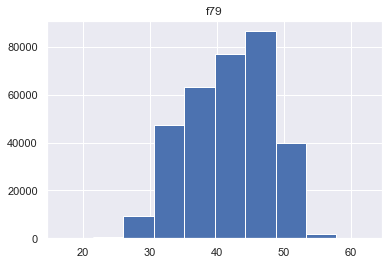

<Figure size 432x288 with 0 Axes>

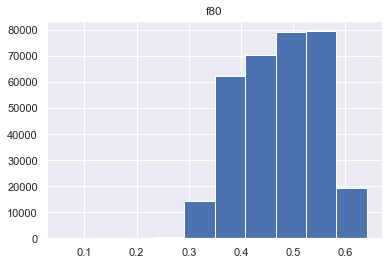

<Figure size 432x288 with 0 Axes>

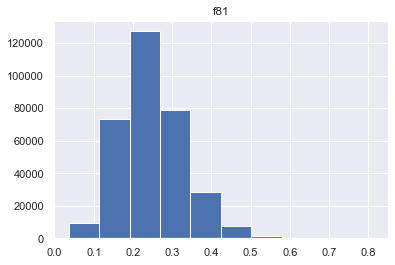

<Figure size 432x288 with 0 Axes>

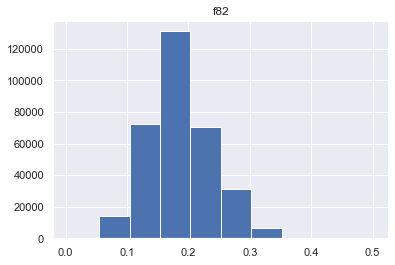

<Figure size 432x288 with 0 Axes>

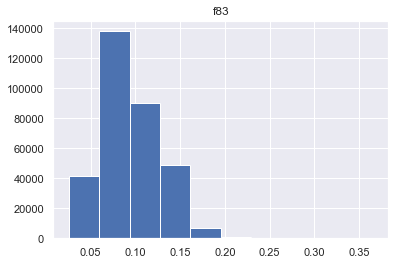

<Figure size 432x288 with 0 Axes>

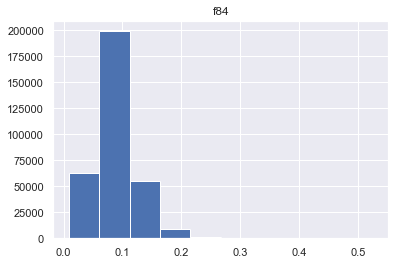

<Figure size 432x288 with 0 Axes>

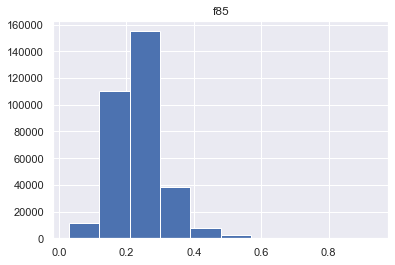

<Figure size 432x288 with 0 Axes>

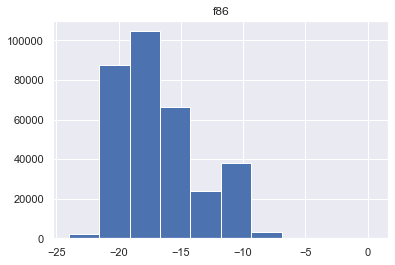

<Figure size 432x288 with 0 Axes>

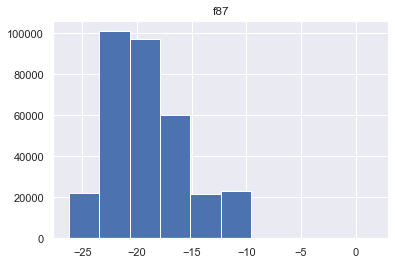

<Figure size 432x288 with 0 Axes>

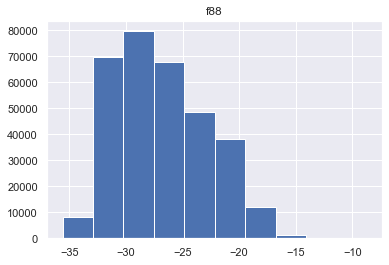

<Figure size 432x288 with 0 Axes>

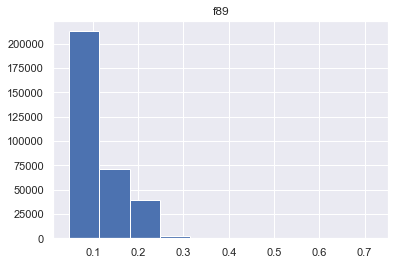

<Figure size 432x288 with 0 Axes>

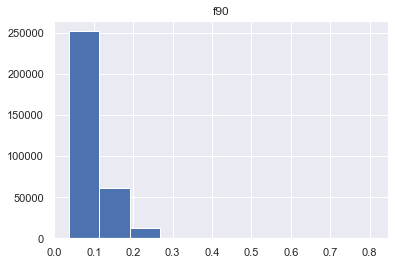

<Figure size 432x288 with 0 Axes>

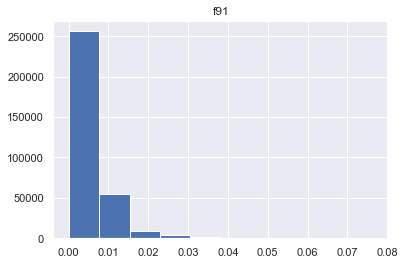

<Figure size 432x288 with 0 Axes>

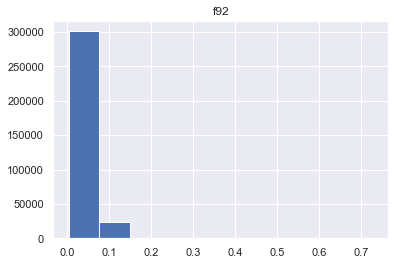

<Figure size 432x288 with 0 Axes>

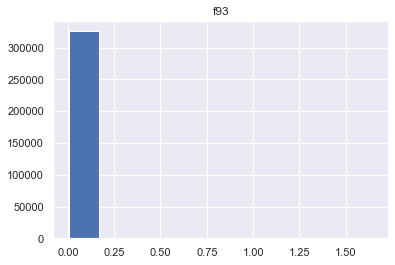

<Figure size 432x288 with 0 Axes>

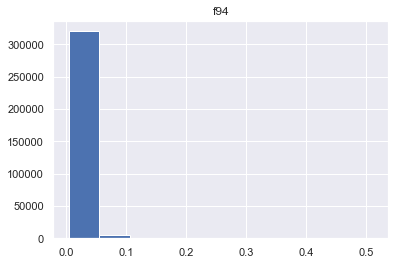

<Figure size 432x288 with 0 Axes>

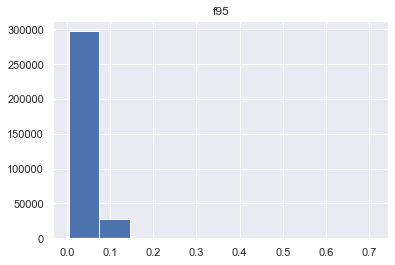

<Figure size 432x288 with 0 Axes>

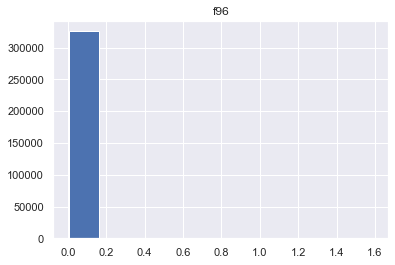

<Figure size 432x288 with 0 Axes>

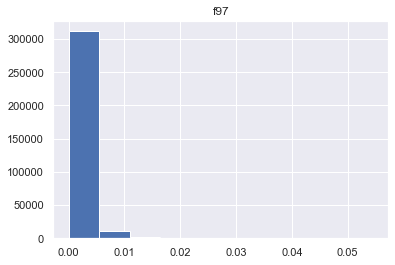

<Figure size 432x288 with 0 Axes>

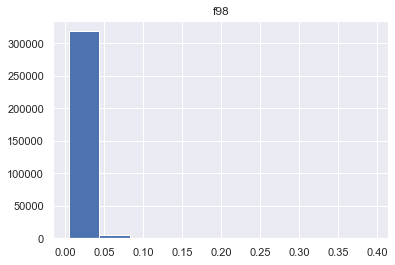

<Figure size 432x288 with 0 Axes>

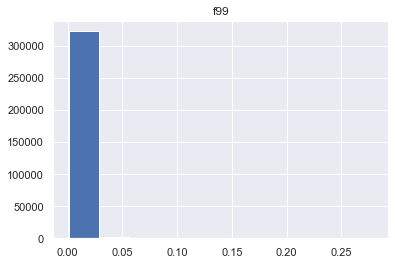

<Figure size 432x288 with 0 Axes>

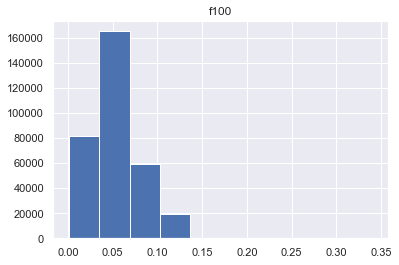

<Figure size 432x288 with 0 Axes>

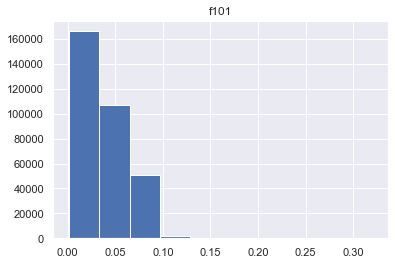

<Figure size 432x288 with 0 Axes>

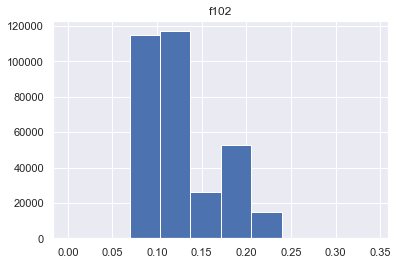

<Figure size 432x288 with 0 Axes>

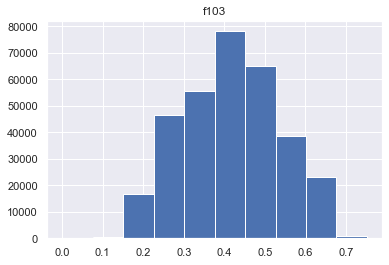

<Figure size 432x288 with 0 Axes>

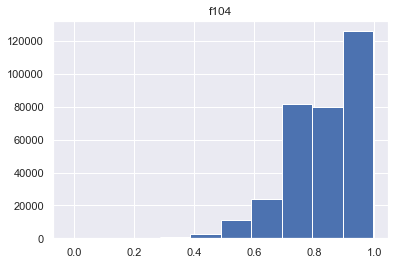

<Figure size 432x288 with 0 Axes>

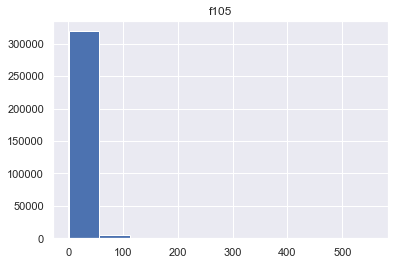

<Figure size 432x288 with 0 Axes>

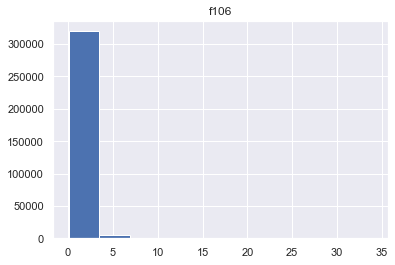

<Figure size 432x288 with 0 Axes>

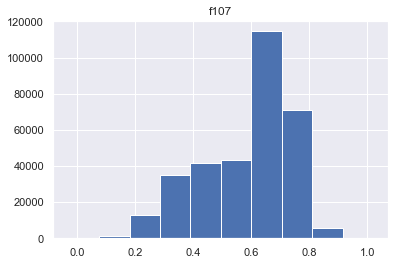

<Figure size 432x288 with 0 Axes>

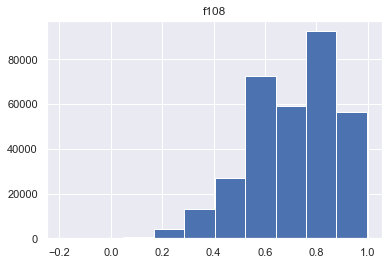

<Figure size 432x288 with 0 Axes>

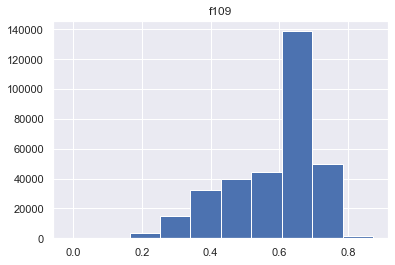

<Figure size 432x288 with 0 Axes>

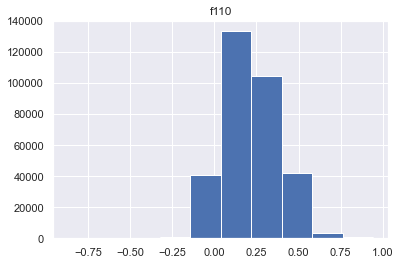

<Figure size 432x288 with 0 Axes>

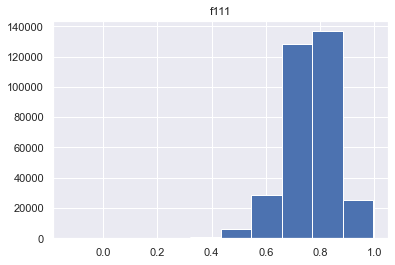

<Figure size 432x288 with 0 Axes>

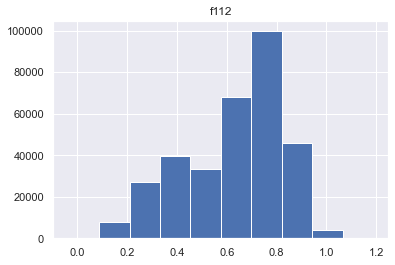

<Figure size 432x288 with 0 Axes>

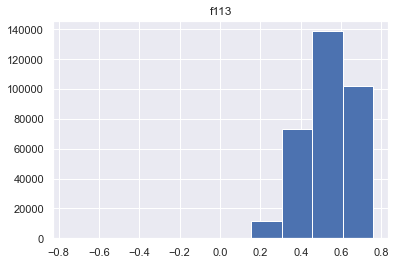

<Figure size 432x288 with 0 Axes>

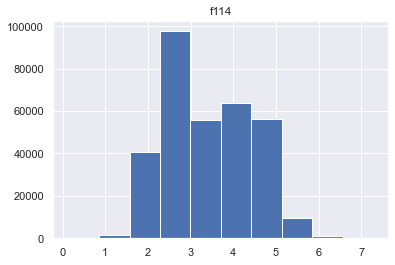

<Figure size 432x288 with 0 Axes>

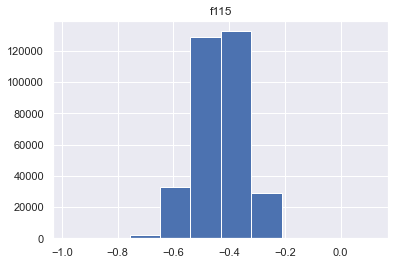

<Figure size 432x288 with 0 Axes>

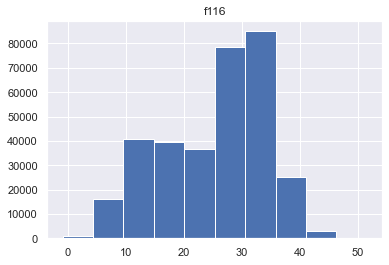

<Figure size 432x288 with 0 Axes>

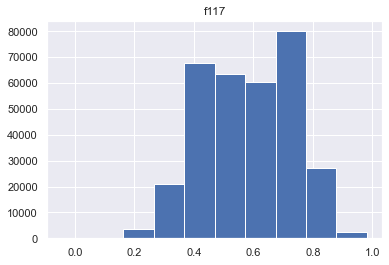

<Figure size 432x288 with 0 Axes>

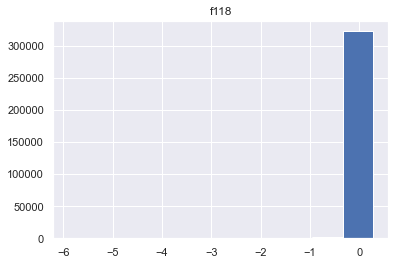

<Figure size 432x288 with 0 Axes>

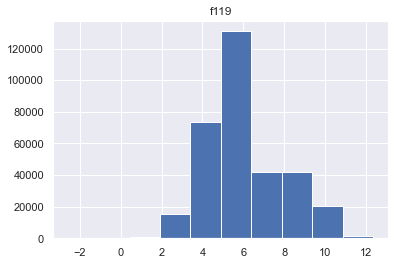

<Figure size 432x288 with 0 Axes>

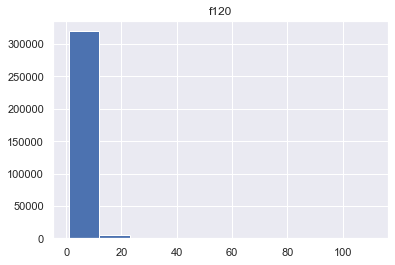

<Figure size 432x288 with 0 Axes>

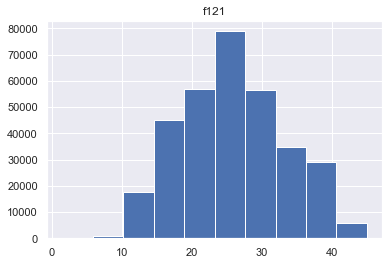

<Figure size 432x288 with 0 Axes>

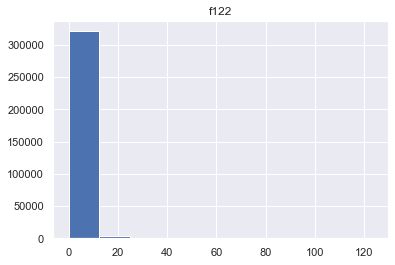

<Figure size 432x288 with 0 Axes>

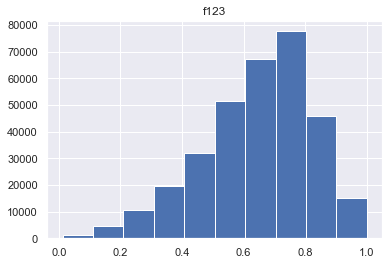

<Figure size 432x288 with 0 Axes>

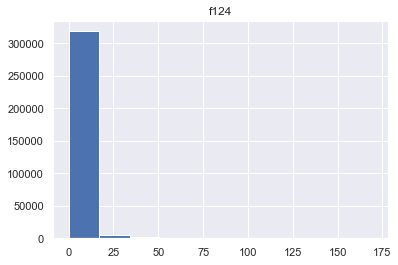

<Figure size 432x288 with 0 Axes>

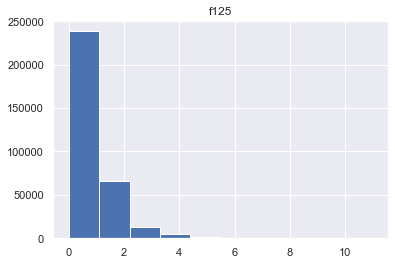

<Figure size 432x288 with 0 Axes>

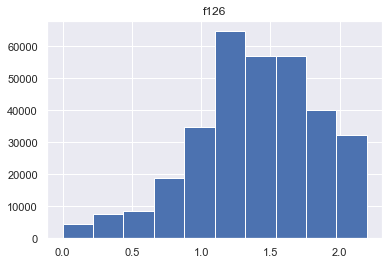

<Figure size 432x288 with 0 Axes>

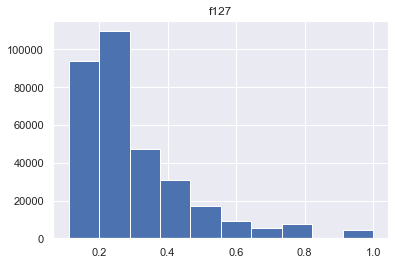

<Figure size 432x288 with 0 Axes>

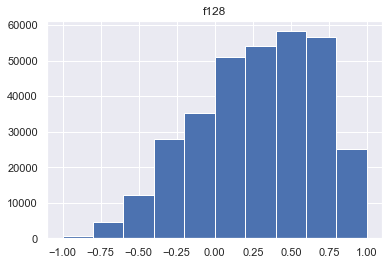

<Figure size 432x288 with 0 Axes>

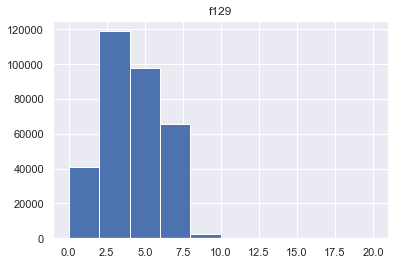

<Figure size 432x288 with 0 Axes>

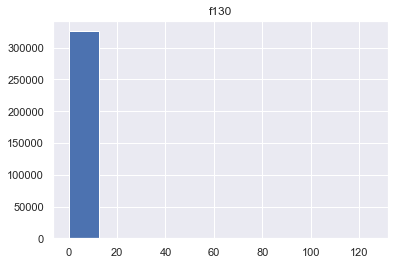

<Figure size 432x288 with 0 Axes>

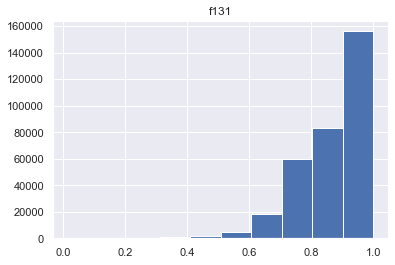

<Figure size 432x288 with 0 Axes>

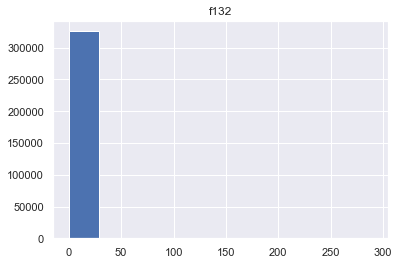

<Figure size 432x288 with 0 Axes>

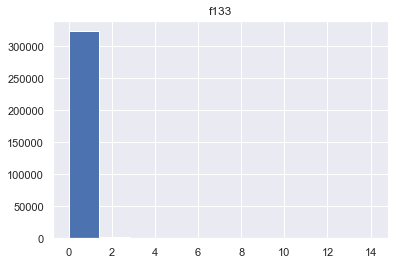

<Figure size 432x288 with 0 Axes>

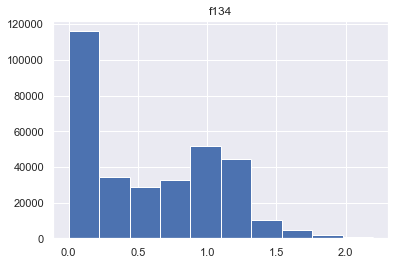

<Figure size 432x288 with 0 Axes>

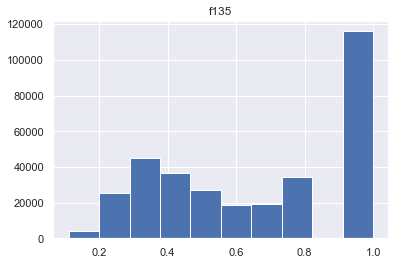

<Figure size 432x288 with 0 Axes>

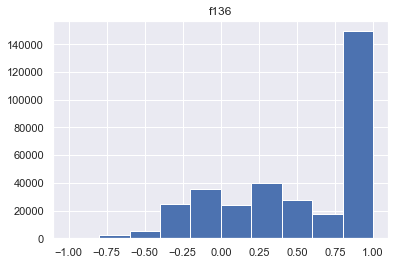

<Figure size 432x288 with 0 Axes>

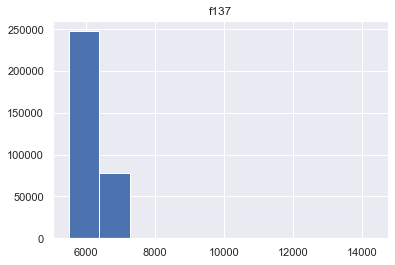

<Figure size 432x288 with 0 Axes>

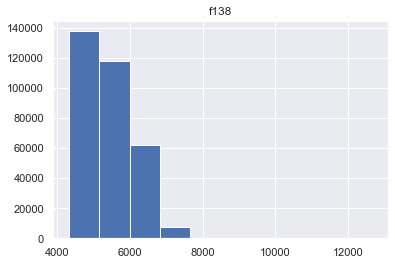

<Figure size 432x288 with 0 Axes>

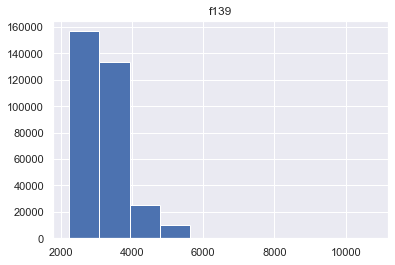

<Figure size 432x288 with 0 Axes>

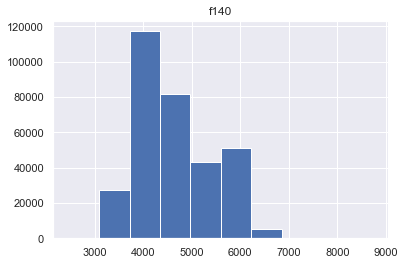

<Figure size 432x288 with 0 Axes>

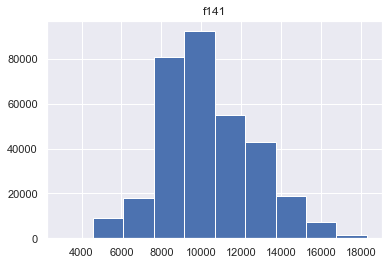

<Figure size 432x288 with 0 Axes>

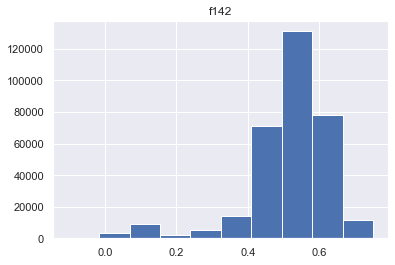

<Figure size 432x288 with 0 Axes>

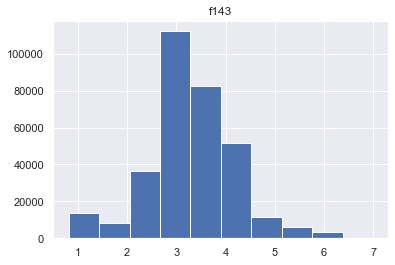

<Figure size 432x288 with 0 Axes>

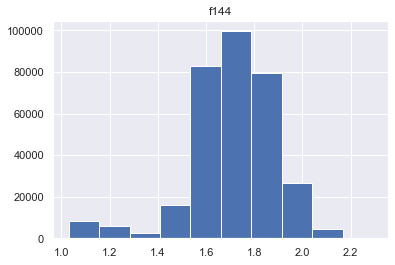

<Figure size 432x288 with 0 Axes>

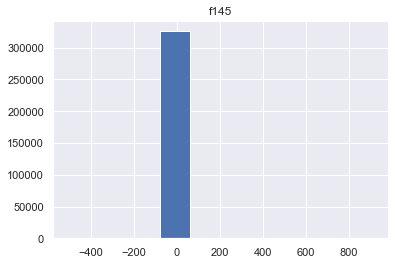

<Figure size 432x288 with 0 Axes>

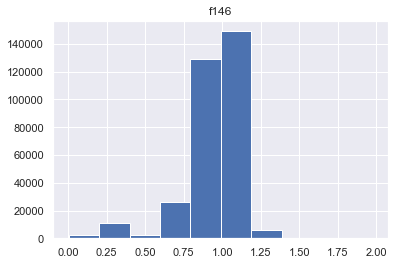

<Figure size 432x288 with 0 Axes>

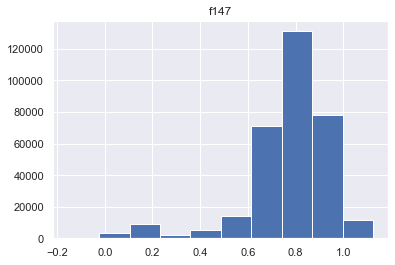

<Figure size 432x288 with 0 Axes>

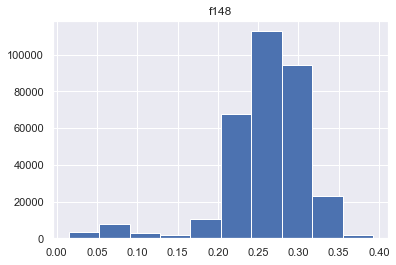

<Figure size 432x288 with 0 Axes>

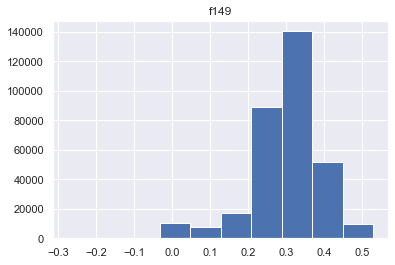

<Figure size 432x288 with 0 Axes>

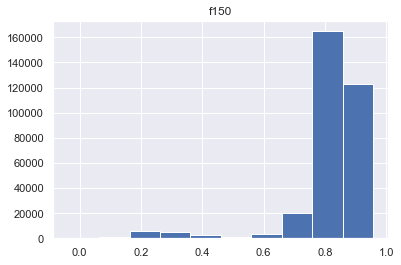

<Figure size 432x288 with 0 Axes>

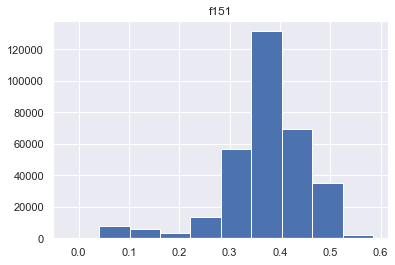

<Figure size 432x288 with 0 Axes>

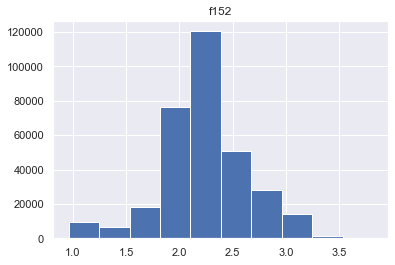

<Figure size 432x288 with 0 Axes>

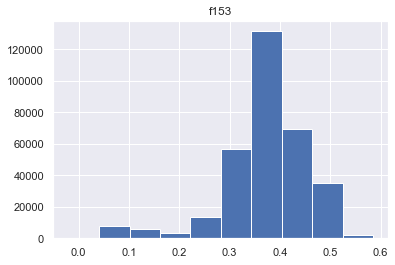

<Figure size 432x288 with 0 Axes>

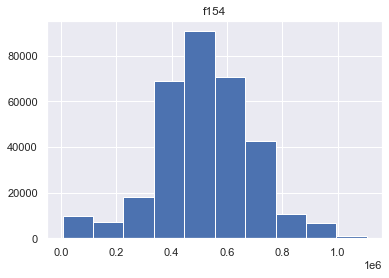

<Figure size 432x288 with 0 Axes>

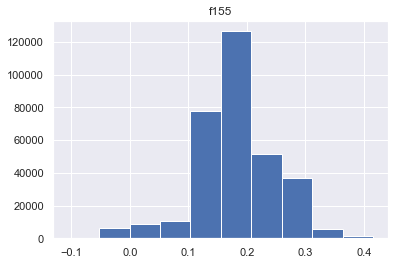

<Figure size 432x288 with 0 Axes>

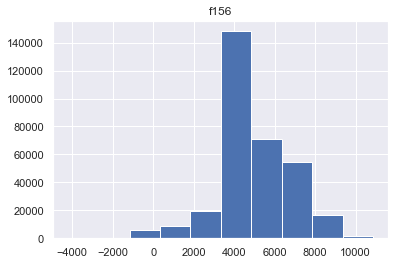

<Figure size 432x288 with 0 Axes>

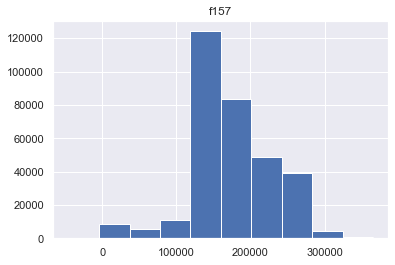

<Figure size 432x288 with 0 Axes>

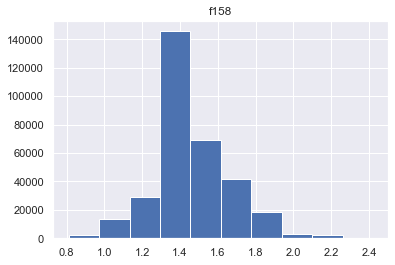

<Figure size 432x288 with 0 Axes>

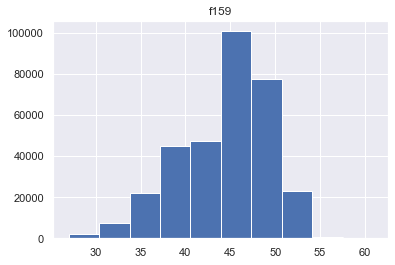

<Figure size 432x288 with 0 Axes>

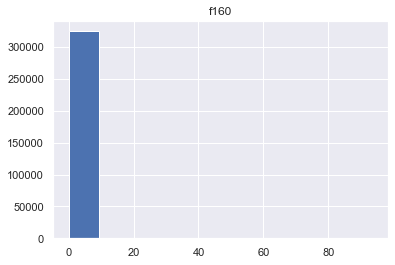

<Figure size 432x288 with 0 Axes>

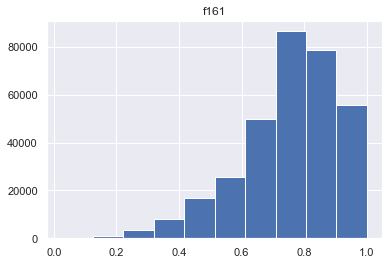

<Figure size 432x288 with 0 Axes>

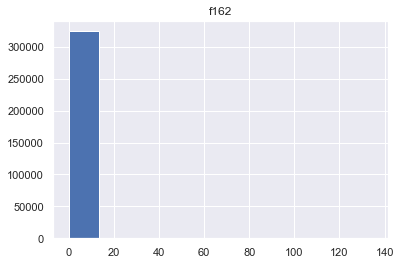

<Figure size 432x288 with 0 Axes>

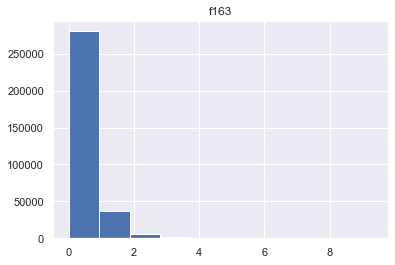

<Figure size 432x288 with 0 Axes>

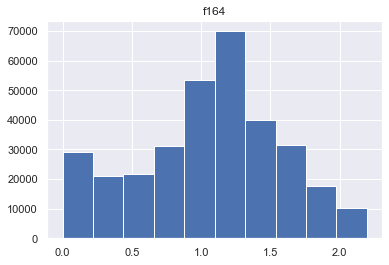

<Figure size 432x288 with 0 Axes>

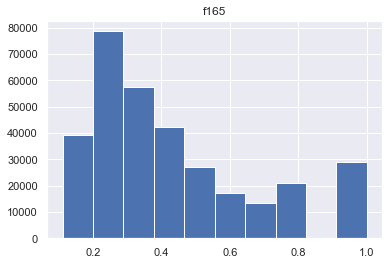

<Figure size 432x288 with 0 Axes>

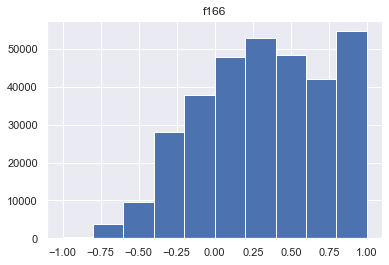

<Figure size 432x288 with 0 Axes>

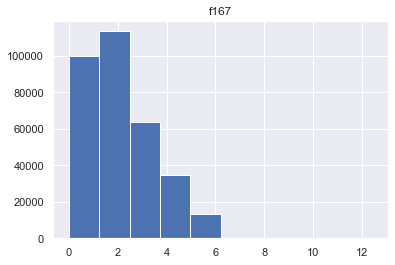

<Figure size 432x288 with 0 Axes>

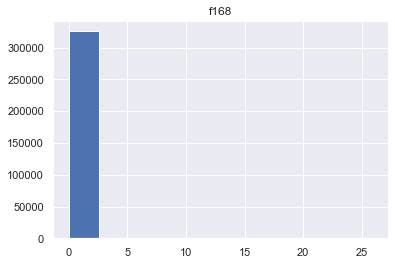

<Figure size 432x288 with 0 Axes>

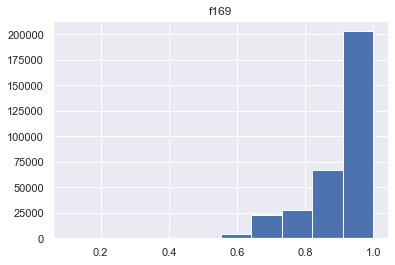

<Figure size 432x288 with 0 Axes>

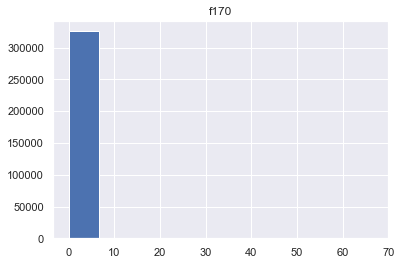

<Figure size 432x288 with 0 Axes>

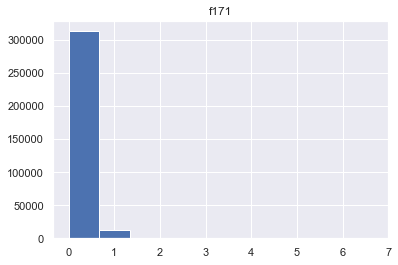

<Figure size 432x288 with 0 Axes>

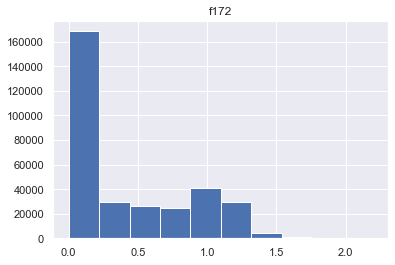

<Figure size 432x288 with 0 Axes>

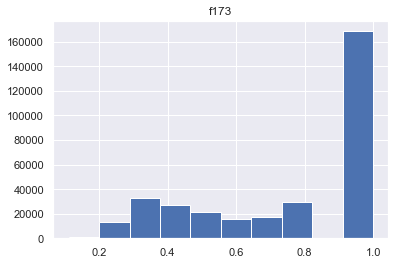

<Figure size 432x288 with 0 Axes>

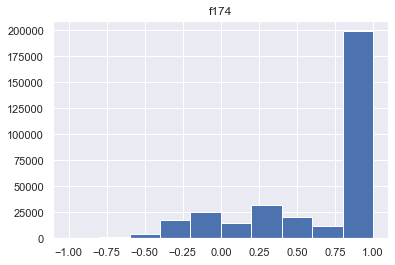

In [6]:
# histograms of dataset attributes
for column in df:
    plt.figure()
    df.hist([column])

<ipython-input-7-3ce495de62b0>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


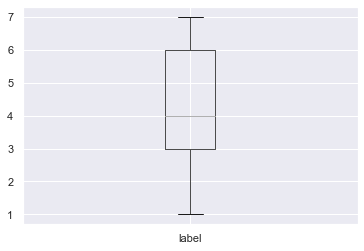

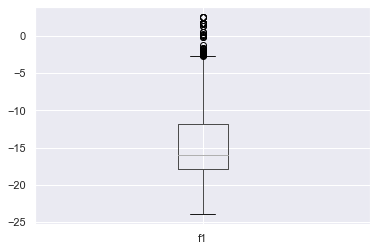

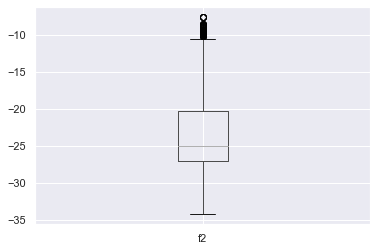

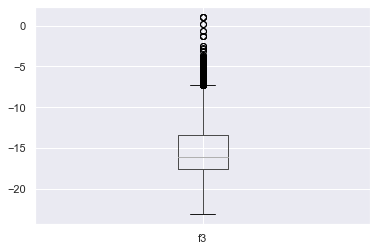

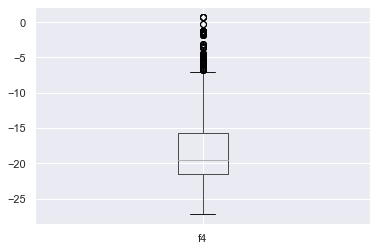

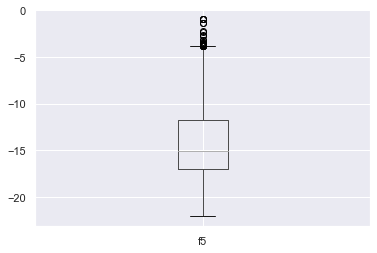

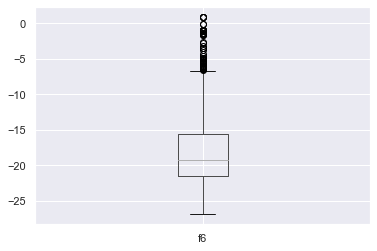

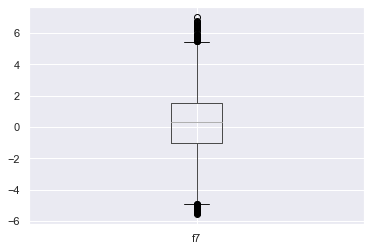

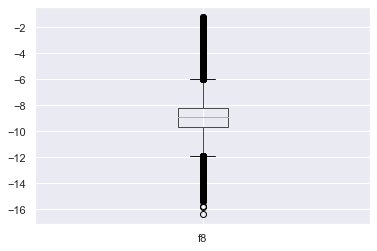

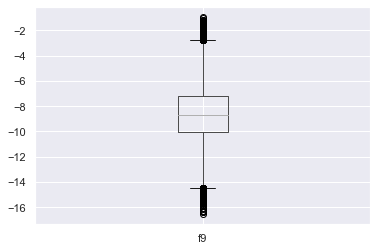

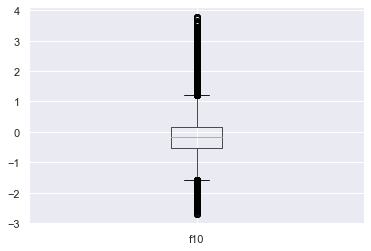

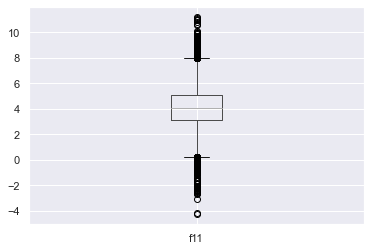

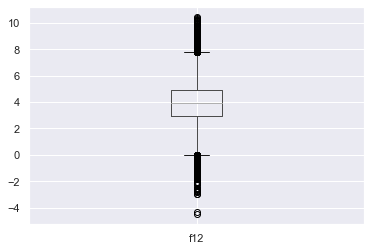

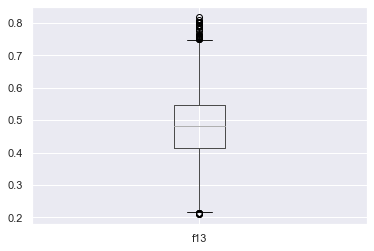

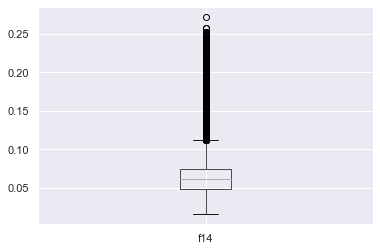

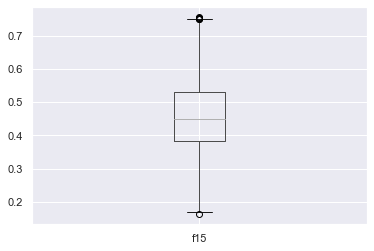

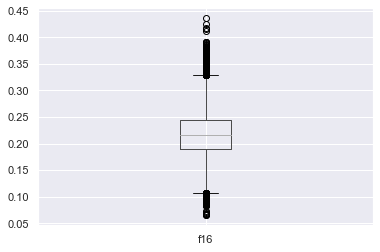

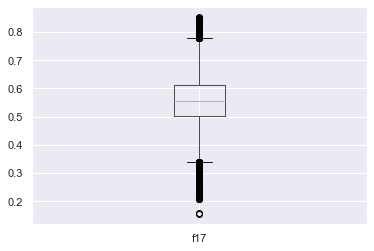

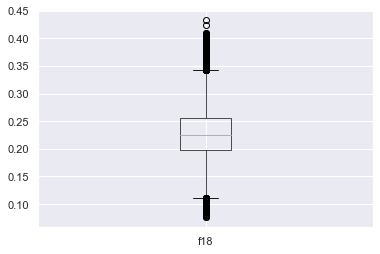

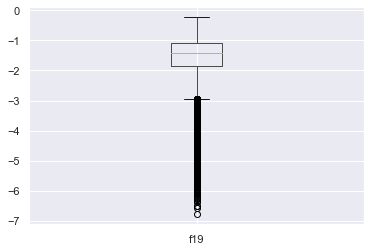

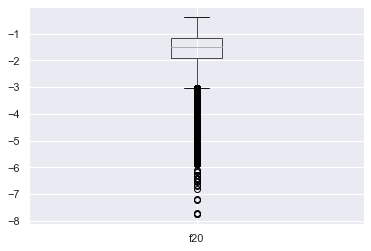

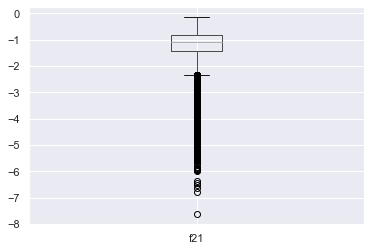

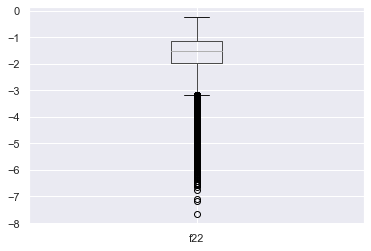

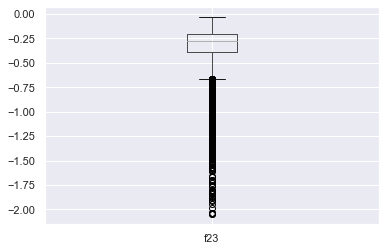

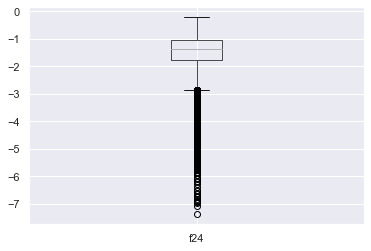

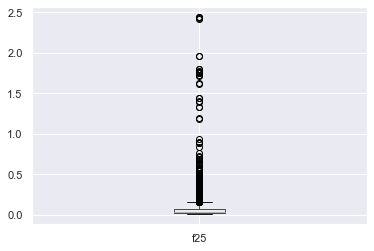

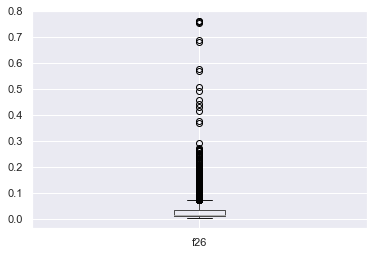

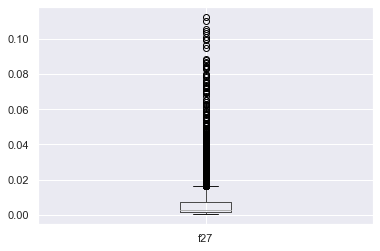

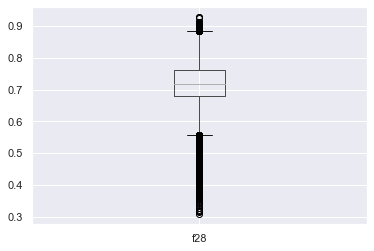

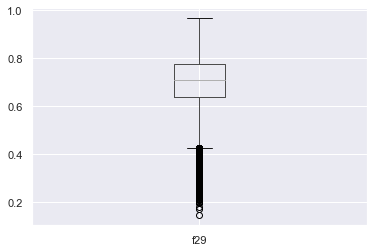

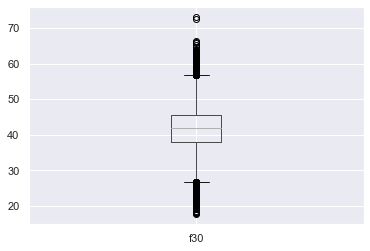

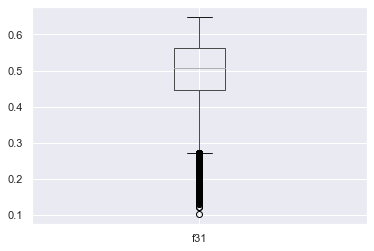

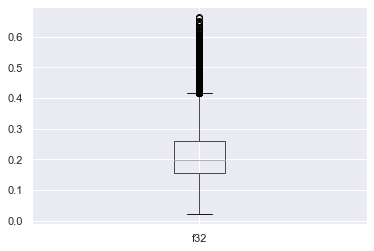

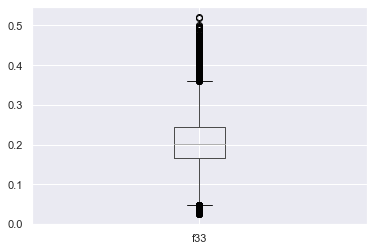

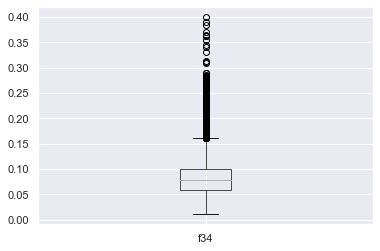

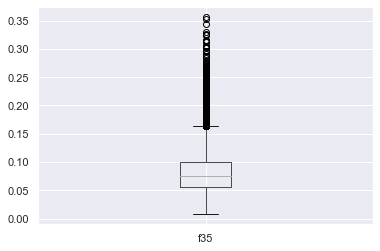

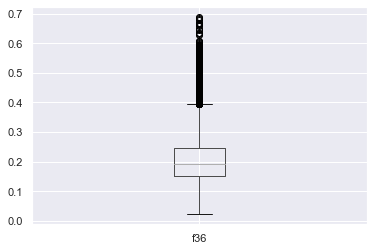

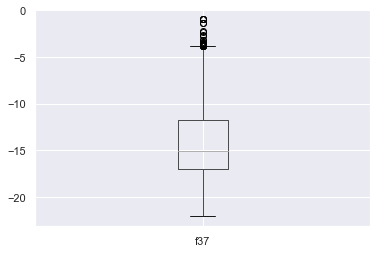

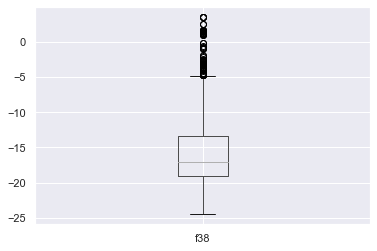

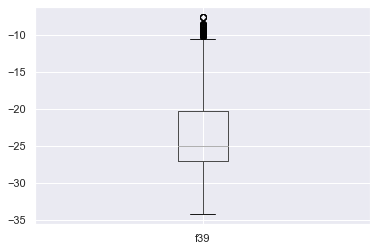

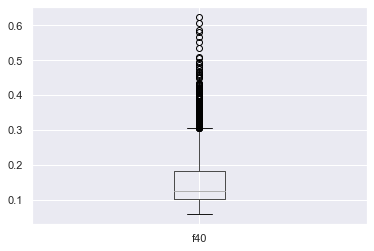

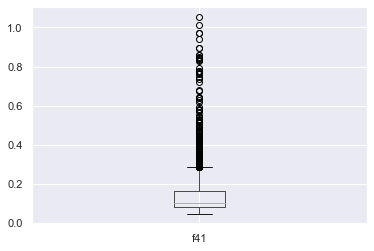

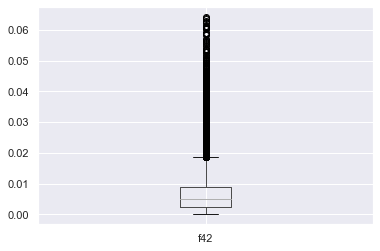

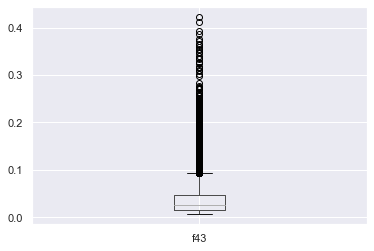

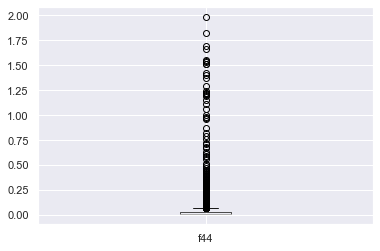

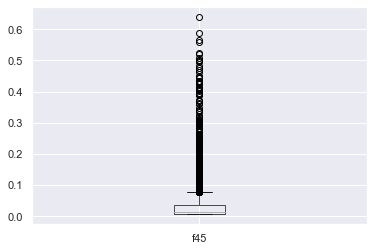

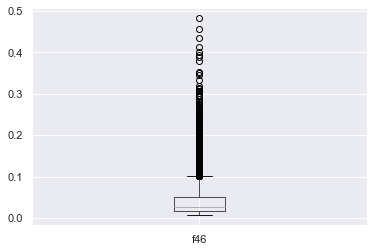

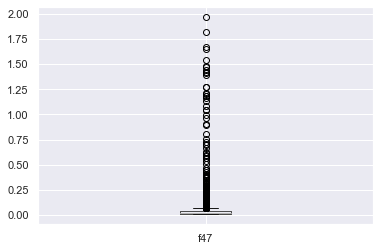

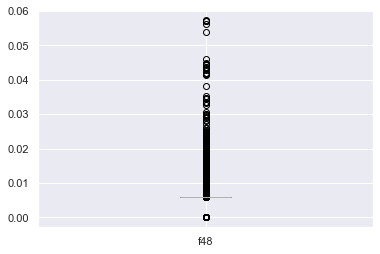

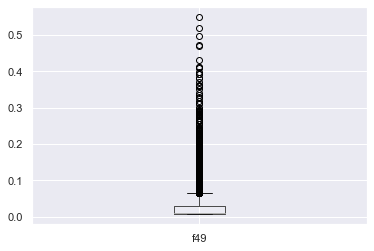

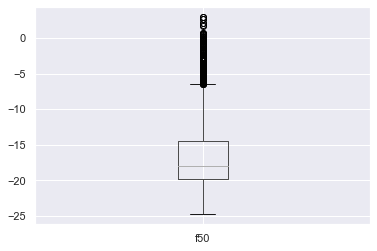

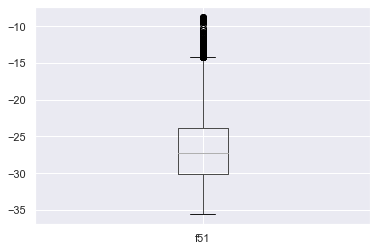

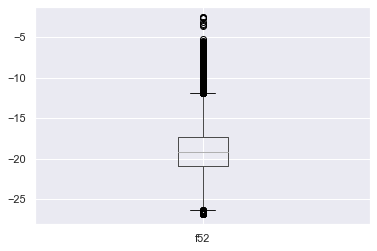

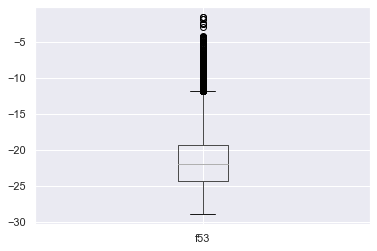

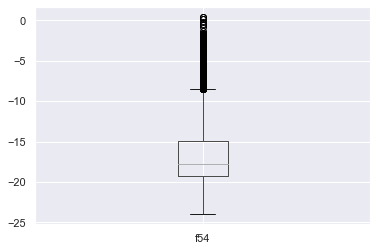

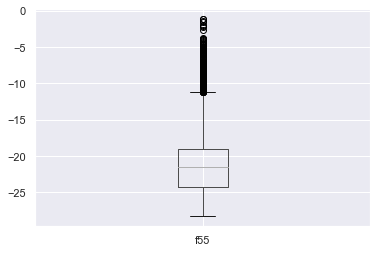

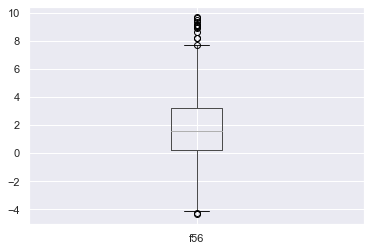

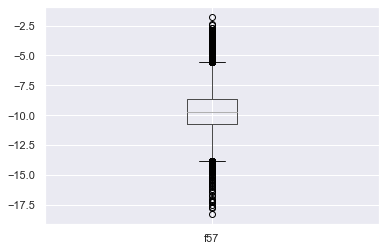

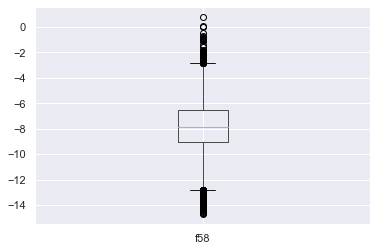

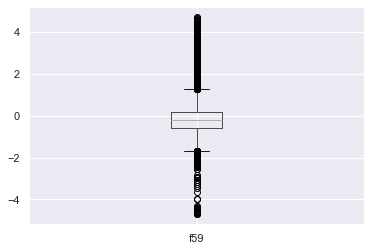

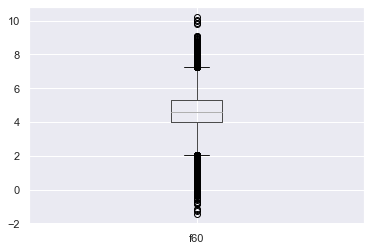

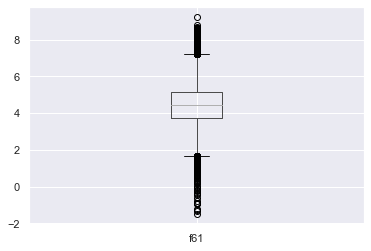

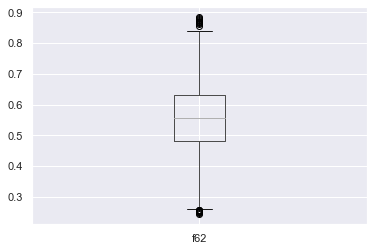

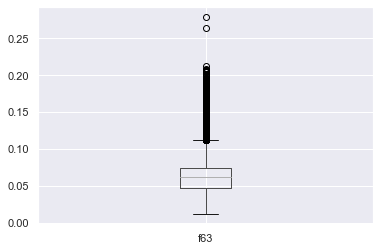

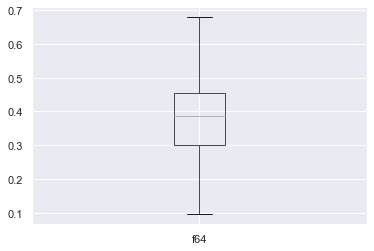

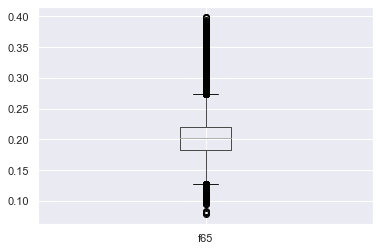

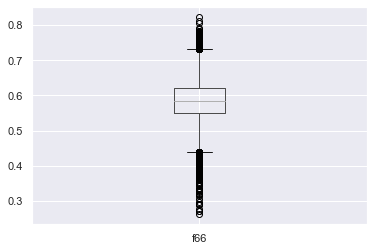

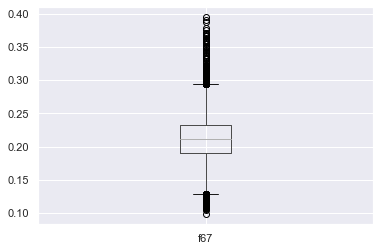

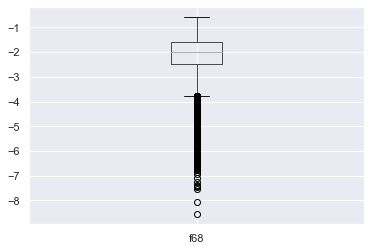

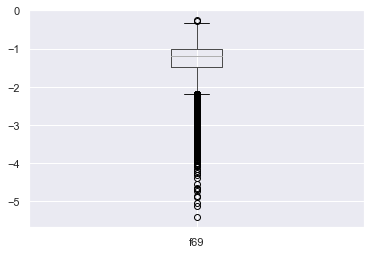

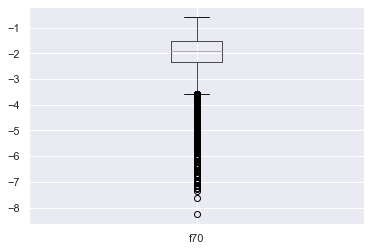

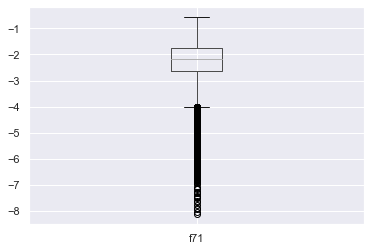

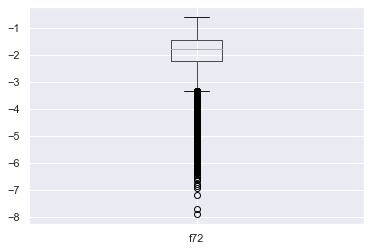

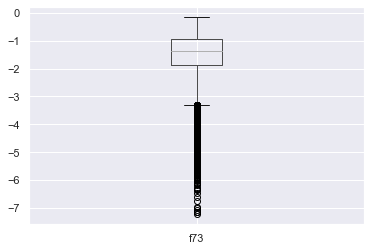

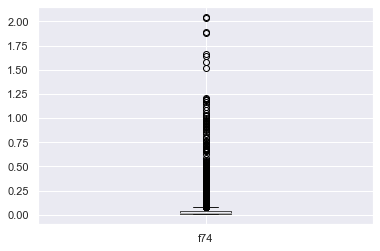

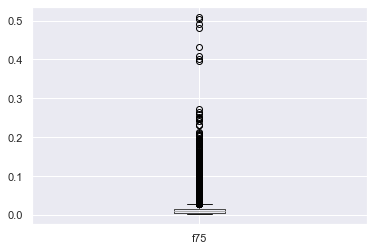

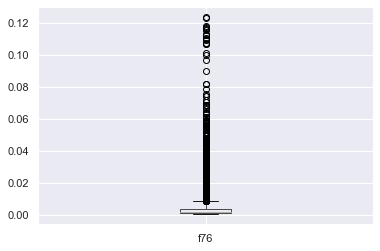

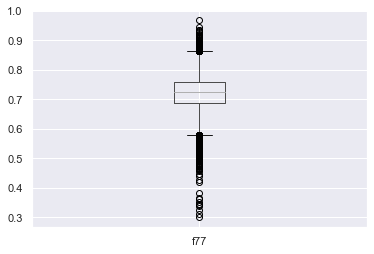

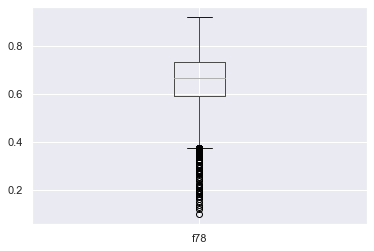

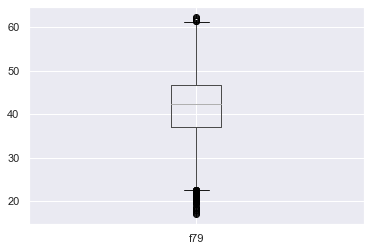

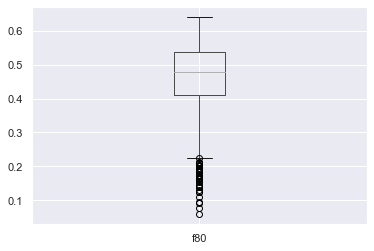

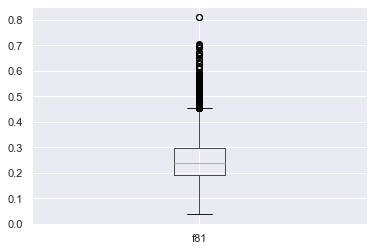

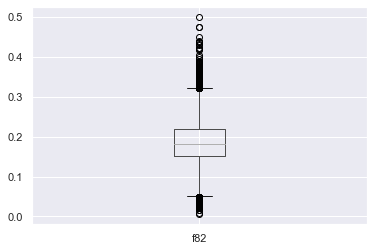

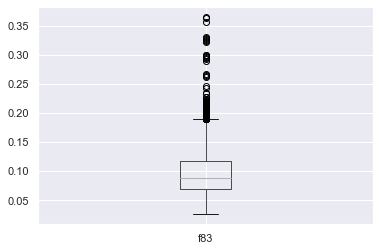

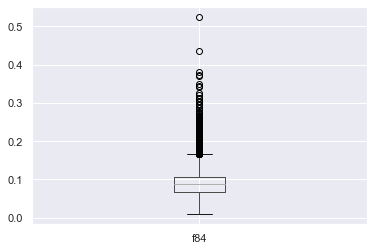

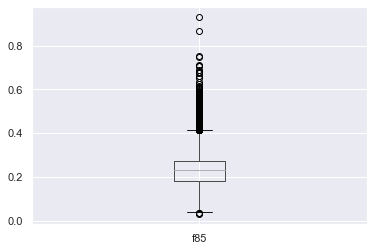

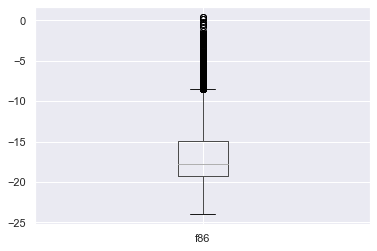

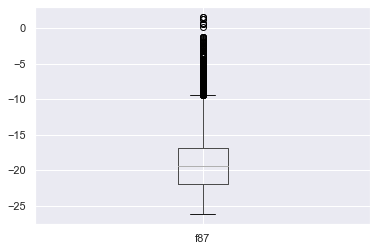

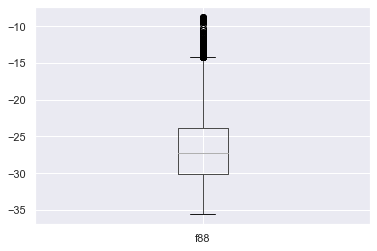

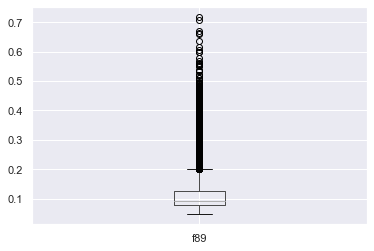

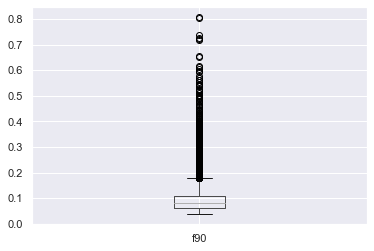

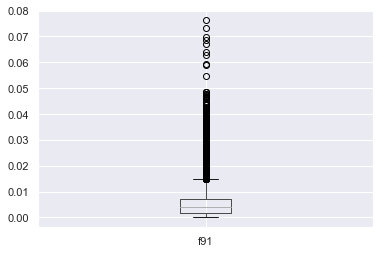

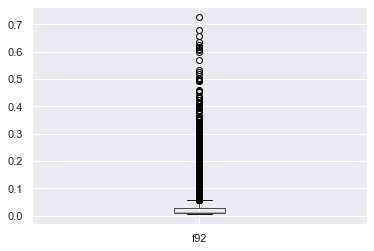

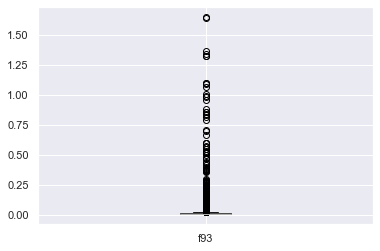

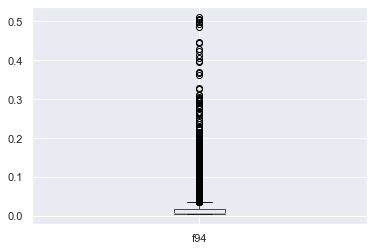

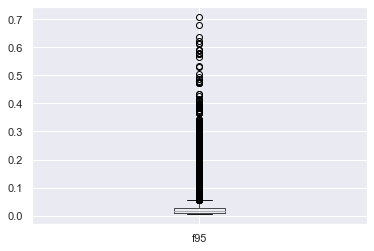

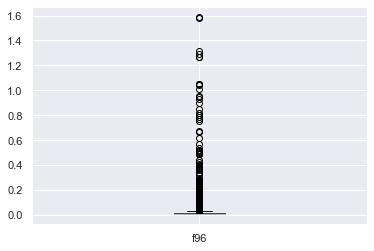

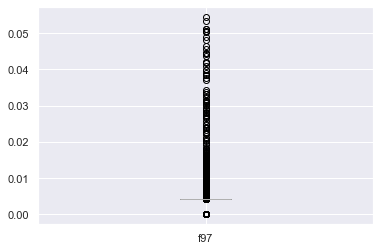

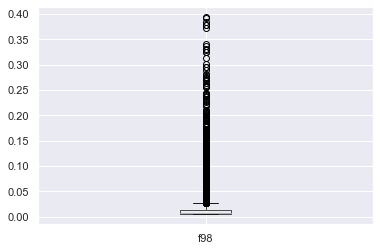

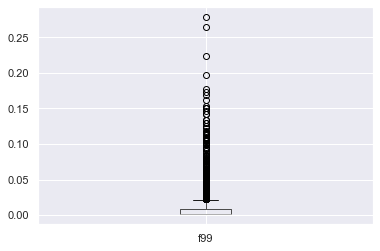

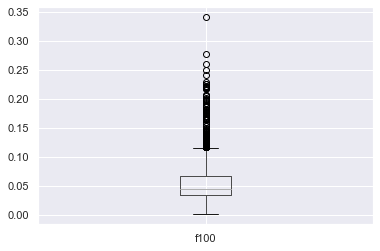

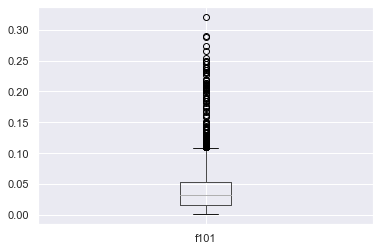

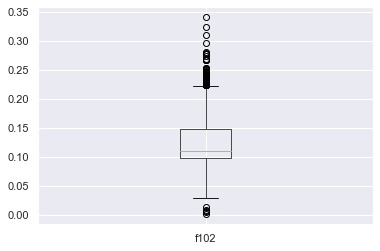

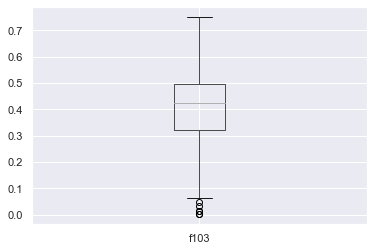

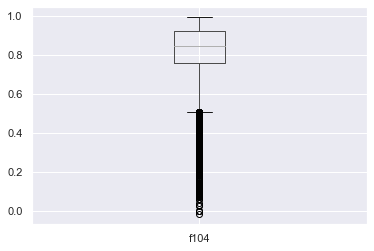

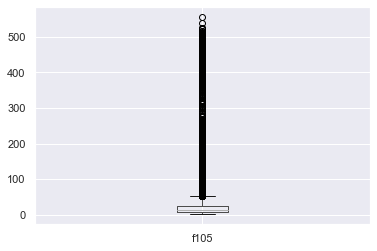

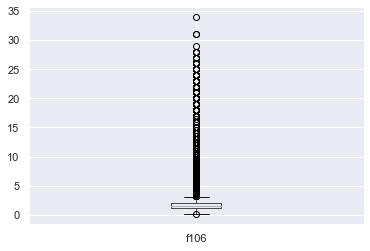

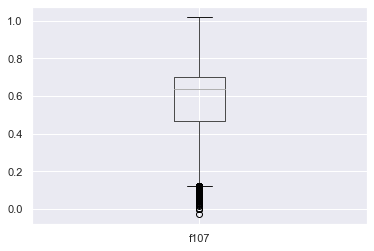

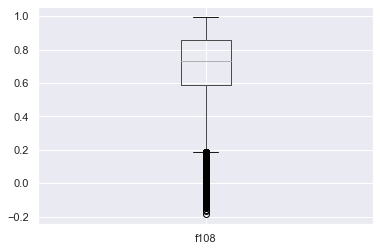

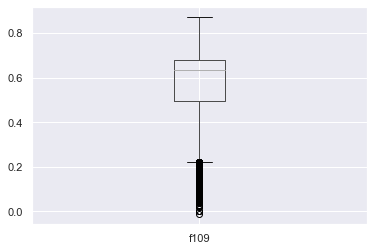

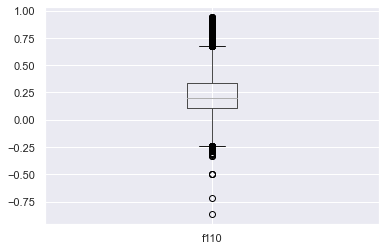

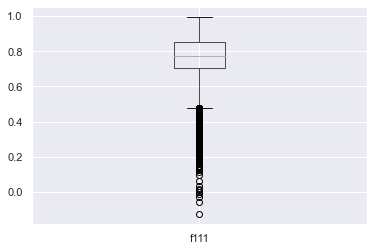

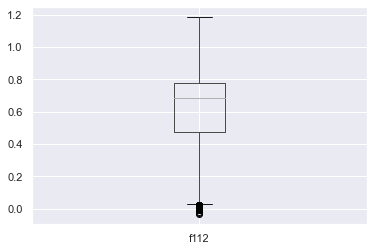

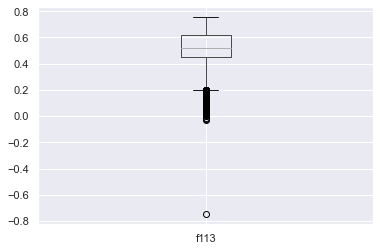

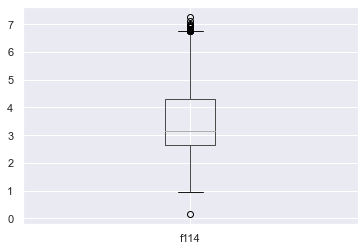

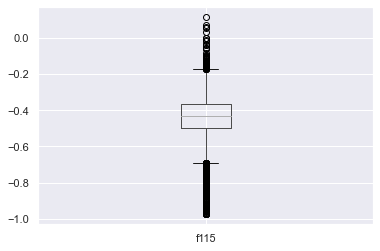

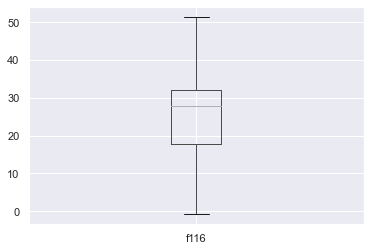

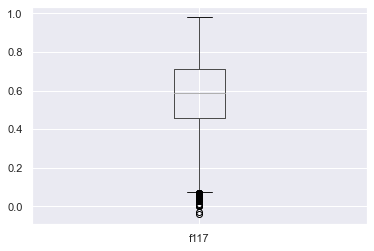

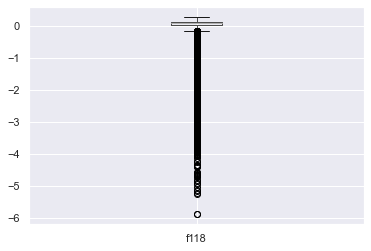

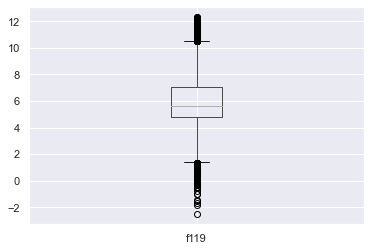

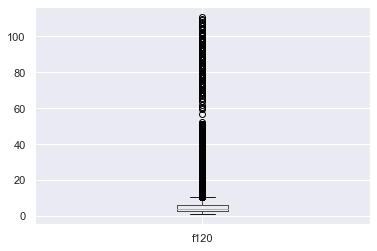

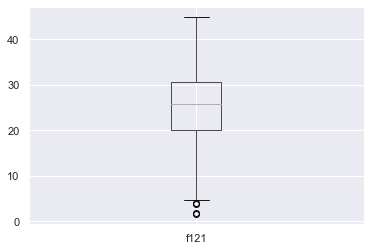

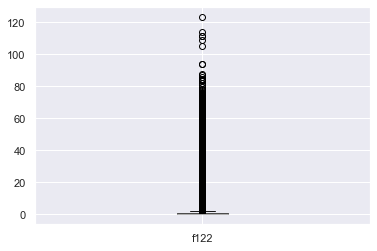

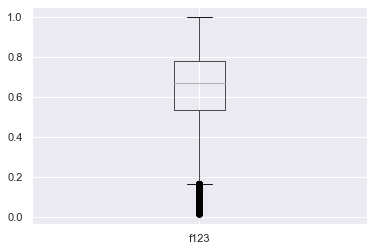

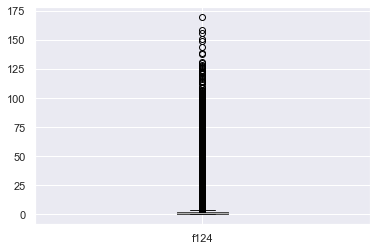

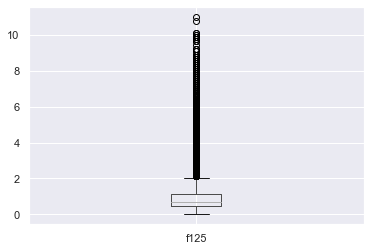

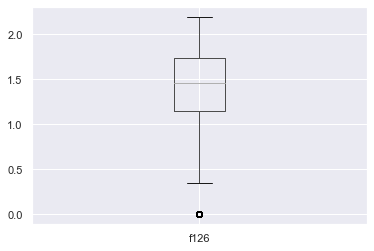

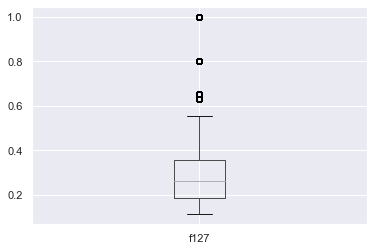

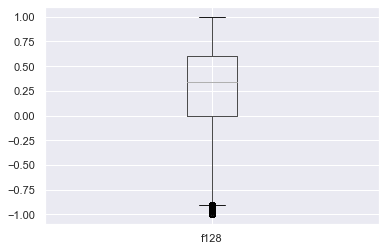

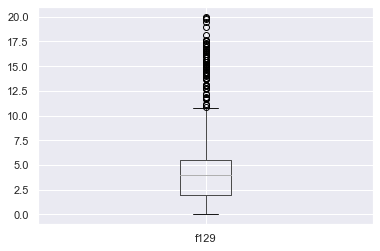

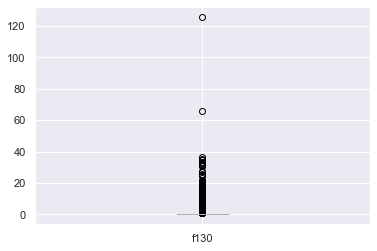

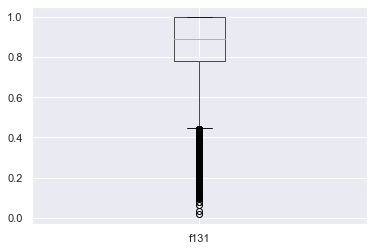

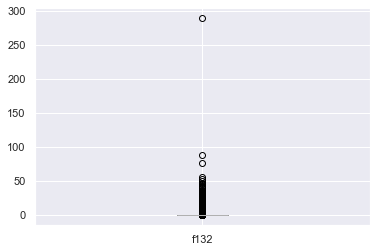

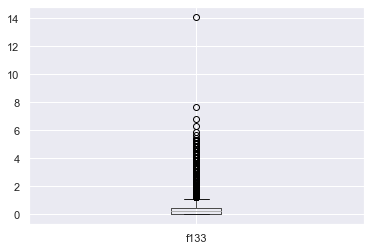

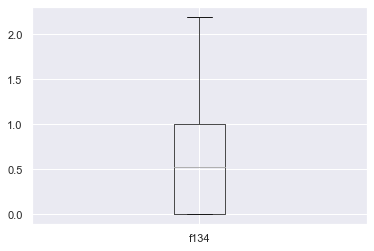

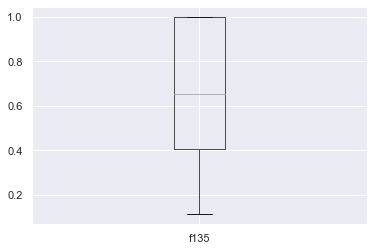

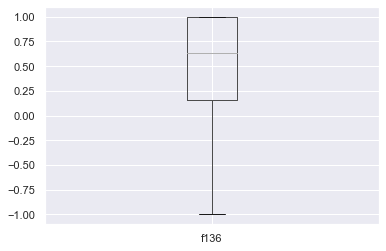

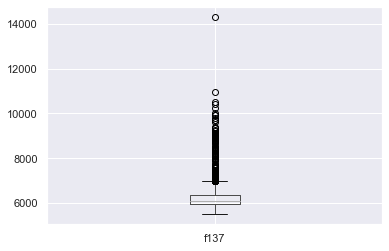

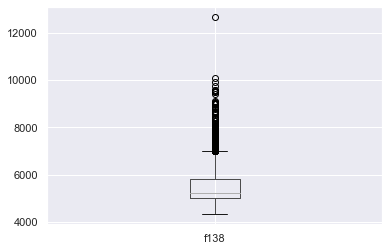

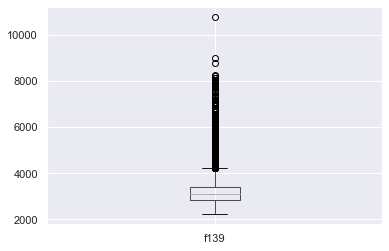

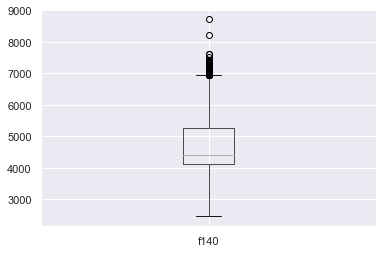

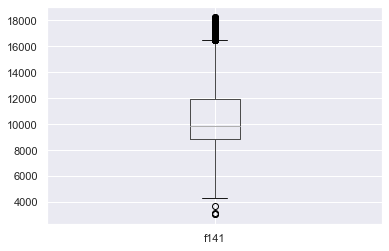

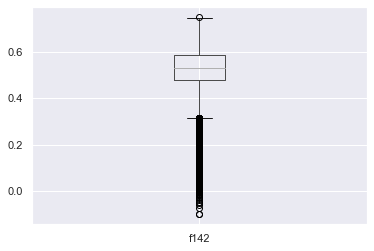

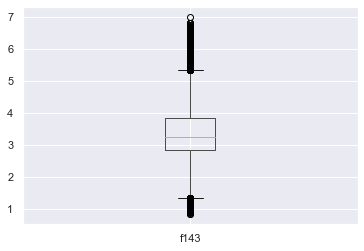

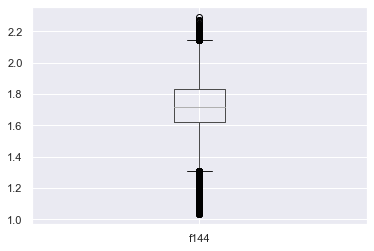

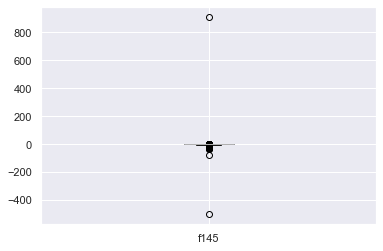

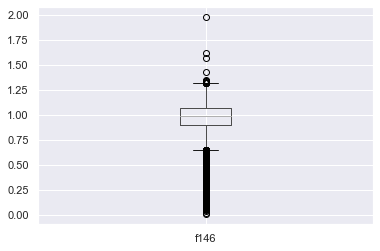

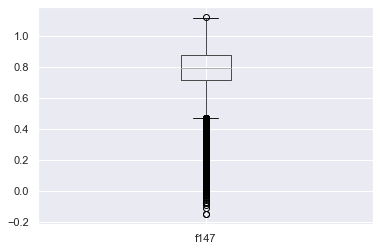

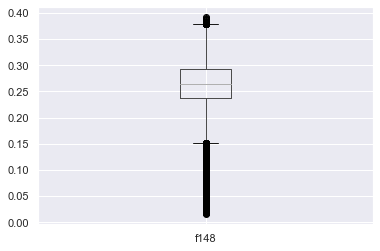

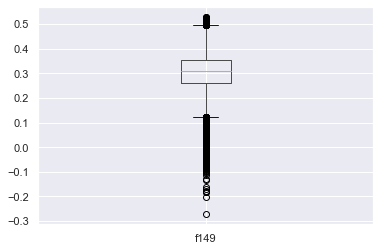

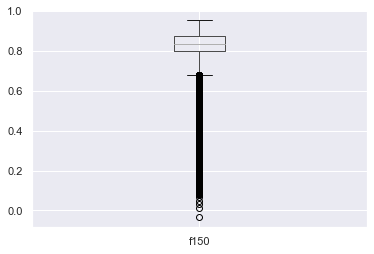

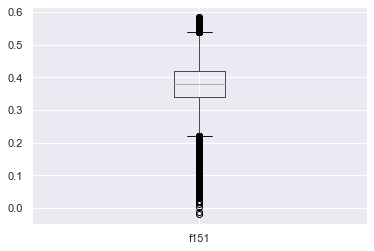

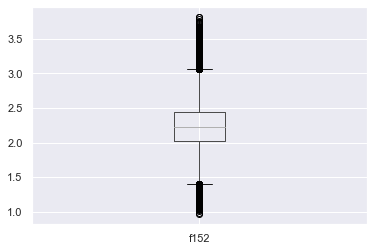

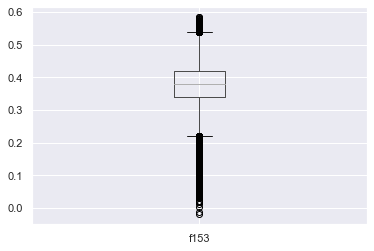

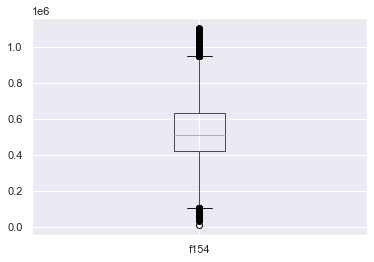

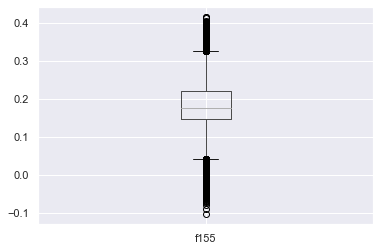

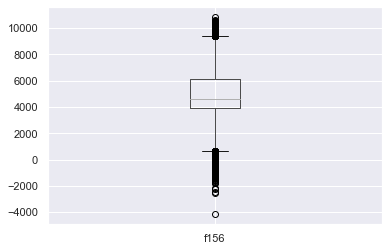

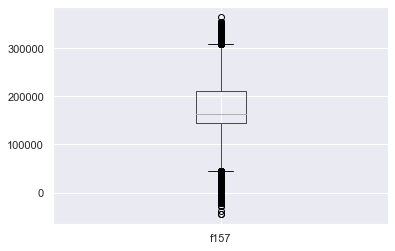

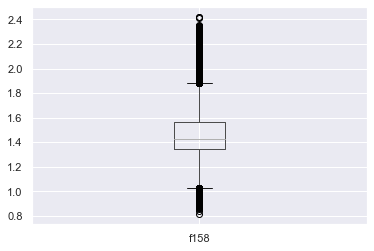

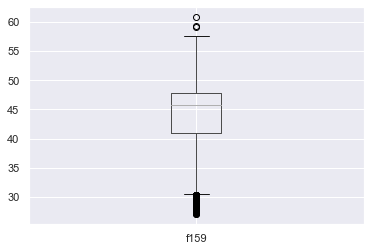

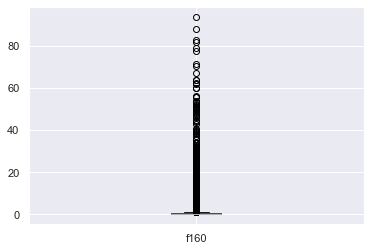

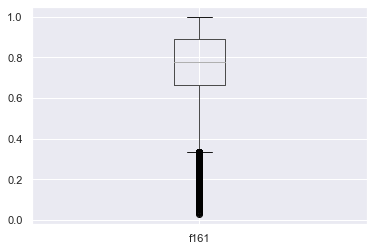

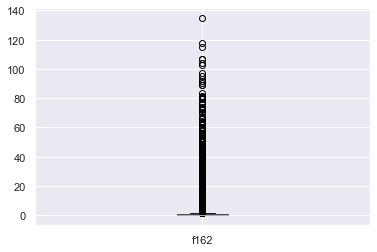

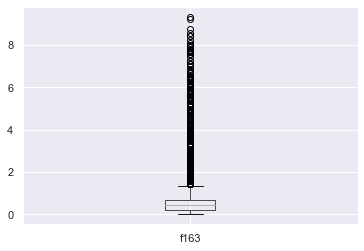

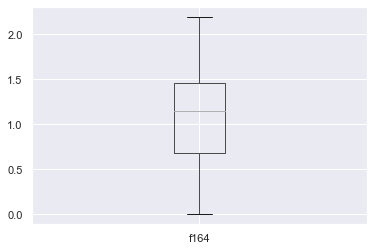

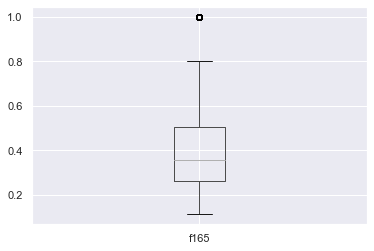

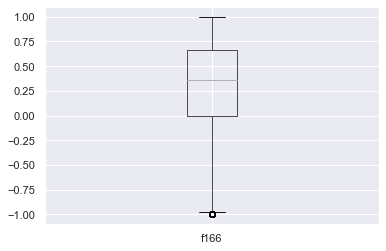

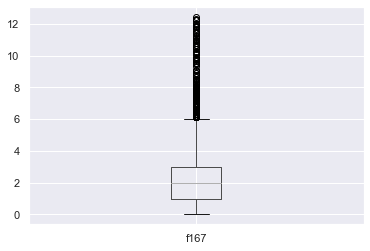

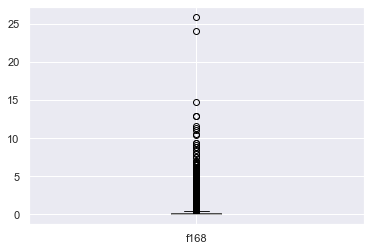

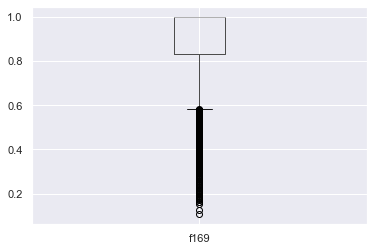

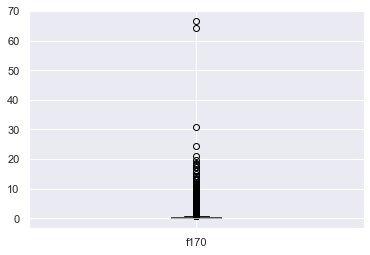

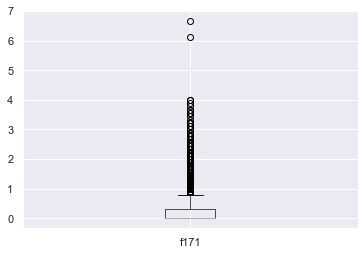

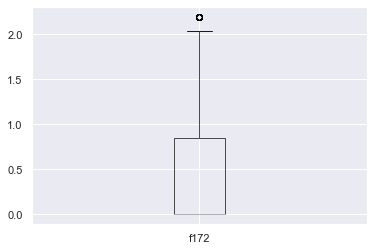

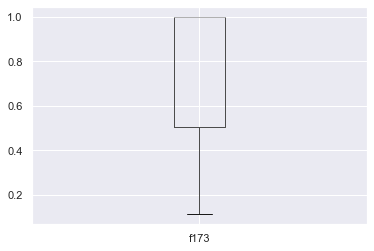

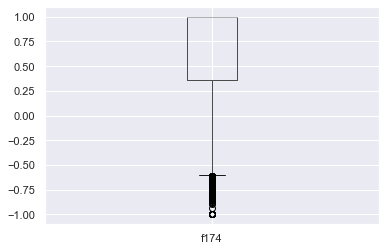

In [7]:
# boxplots of dataset attributes
for column in df:
    plt.figure()
    df.boxplot([column])

In [8]:
# descriptive statistics of attributes
print(df.describe(include='all'))

           label         f1         f2         f3         f4         f5  \
count 325834.000 325834.000 325834.000 325834.000 325834.000 325834.000   
mean       4.062    -15.144    -24.026    -15.400    -18.594    -14.493   
std        1.605      3.504      4.054      3.268      3.712      3.189   
min        1.000    -23.971    -34.308    -23.161    -27.245    -22.103   
25%        3.000    -17.848    -27.119    -17.563    -21.449    -16.989   
50%        4.000    -15.992    -25.064    -16.164    -19.588    -15.099   
75%        6.000    -11.786    -20.387    -13.427    -15.650    -11.735   
max        7.000      2.536     -7.589      1.104      0.775     -0.887   

              f6         f7         f8         f9        f10        f11  \
count 325834.000 325834.000 325834.000 325834.000 325834.000 325834.000   
mean     -18.427      0.256     -8.882     -8.626     -0.166      4.100   
std        3.676      1.682      1.204      2.003      0.596      1.500   
min      -26.897     -5.

It was decided not to drop any features or remove any outliers. Outliers were not removed because in remote sensing each value of attribute corresponds to a pixel in the output remote sensing image. In essesnce by removing that value you would not be able to classify that pixel.

## Split Dataset

In [10]:
# prepare data for train/test split
X = df.drop("label", 1)
y = df['label']

In [11]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
# standardize the X dataset
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Reduce Dimensions Using Principal Component Analysis

In [13]:
# run base PCA using all components
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Text(0, 0.5, 'cumulative explained variance')

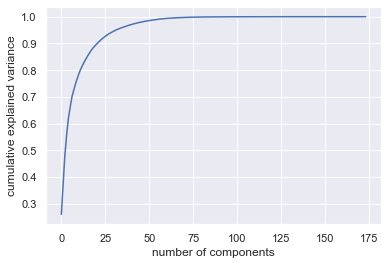

In [14]:
# plot variance explained by number of components in PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [15]:
# 11 components were determined to give the highest accuracy when running base RandomForestClassifier
pca = PCA(n_components = 11)
X_train_pca11 = pca.fit_transform(X_train)
X_test_pca11 = pca.transform(X_test)

## Fine Tune Hyperparameters of Random Forest Classifier

In [16]:
# next sections uses random grid and search to fine tune hyperparameters of RandomForest classifier

n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [17]:
# create RandomForest classifier
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

In [18]:
# create RandomizedSearch object with parameters
from sklearn.model_selection import RandomizedSearchCV
classifier_random = RandomizedSearchCV(estimator = classifier,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
# run the RandomizedSearch classifier on training data to determine best parameters for RandomForest classifier run
classifier_random.fit(X_train_pca11, y_train)

In [ ]:
# print random grid parameters
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', classifier_random.best_params_, ' \n')

## Random Forest Classifier Model

In [19]:
# run the RandomForest classifier using fine tuned settings
from sklearn.ensemble import RandomForestClassifier

classifier_finetune = RandomForestClassifier(n_estimators=50, min_samples_split=6, min_samples_leaf=1, max_features='sqrt', max_depth=100, bootstrap=False, random_state=0)
classifier_finetune.fit(X_train_pca11, y_train)

# Predicting the Test set results
y_pred = classifier_finetune.predict(X_test_pca11)

In [20]:
# create confusion matrix and calculate accuracy and cohen's kappa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

cm = confusion_matrix(y_test, y_pred)
print(cm, ' \n')
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))

[[11806     3     5    27     3     5     7]
 [    2  1065     1     2     0     0     0]
 [    2     2 22794    22     3    11     0]
 [   27     0    28 22219    32    30     0]
 [   25     0    12    55 13510   365     6]
 [   19     0    14    34   178 25089     3]
 [   15     3     0     0     1     3   323]]  

              precision    recall  f1-score   support

           1       0.99      1.00      0.99     11856
           2       0.99      1.00      0.99      1070
           3       1.00      1.00      1.00     22834
           4       0.99      0.99      0.99     22336
           5       0.98      0.97      0.98     13973
           6       0.98      0.99      0.99     25337
           7       0.95      0.94      0.94       345

    accuracy                           0.99     97751
   macro avg       0.99      0.98      0.98     97751
weighted avg       0.99      0.99      0.99     97751

Accuracy: 0.9903325797178546
Cohen's Kappa: 0.9877709636057277
